In [1]:
import pickle, os, math
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
import numpy as np
from software.MantidData import mantidOutput

root_path = os.getcwd()+'/'

### Reading Exper data and Exp_setup for simulation
def generate_exp_k_path(path_descriptions):
    'path description: list(K_path: str([[h1,k1,l1], [h2,k2,l2]]), Value: np.ndarray([h_value, k_value ,l_vaule]), grid: int(number))'
    'example usage: ["[[-h-1, 0, 0.5], [0, k+1, 0.5]]", [1, 1, 0], 300]] or ["[[1, -k, 0.5], [1, k, 0.5]]", [0, 2, 0], 300]'

    desc = path_descriptions[0]
    Kv = path_descriptions[1]
    path = eval(desc, {"h": Kv[0], "k": Kv[1], "l": Kv[2]})
    path.append(path_descriptions[2])

    return path

paths = ["[[1, -k, 0.5], [1, k, 0.5]]", "[[-h, 2, 0.5], [h, 2, 0.5]]", "[[-h-1, 0, 0.5], [0, k+1, 0.5]]"]

### In future the "txt file" can be subsitute to the experiment measurement function or the interface to the equipment
Expr = {0:{'Exp_info':['1K0E_slice_rotation_Ei70meV_5K.txt', paths[0]]}, 1:{'Exp_info':['H20E_slice_rotation_Ei70meV_5K.txt', paths[1]]}, 2:{'Exp_info':['Hm1Hp10E_slice_rotation_Ei70meV_5K.txt', paths[2]]}}

### part for furture application
Expr_grid = [None, None] #[Energy_grid, Kpath_grid]
ori_res = []
for i in Expr.keys():
    testfile = f"{root_path}files/data/{Expr[i]['Exp_info'][0]}"
    MO = mantidOutput(testfile)
    K = max(np.abs(np.min(np.round(MO.XX, 4))), np.abs(np.max(np.round(MO.XX, 4))))
    print(min(MO.XX),max(MO.XX))
    Expr[i]['Exp_info'].append(K)
    Expr[i]['Exp_Kgrid'] = [generate_exp_k_path([Expr[i]['Exp_info'][1], [K,K,K], len(MO.XX) if Expr_grid[0] is None else Expr_grid[0]]), K]
    Expr[i]['Exp_Egrid'] = [np.min(np.round(MO.YY, 4)), np.max(np.round(MO.YY, 4)), len(MO.YY) if Expr_grid[1] is None else Expr_grid[1]]
    ori_res.append(MO.II)

### Simulation_setup
img_shape = [500, 500] #[Energy_grid, Kpath_grid]
exp_img_shape = [[Expr[i]['Exp_Egrid'][2], Expr[i]['Exp_Kgrid'][0][2]] for i in Expr.keys()]

print(exp_img_shape)

# simulation Q and E for SpinW Simulation
Q_paths = [[Expr[i]['Exp_Kgrid'][0][0], Expr[i]['Exp_Kgrid'][0][1], img_shape[1]] for i in Expr.keys()] 
E_grid = [[Expr[i]['Exp_Egrid'][0], Expr[i]['Exp_Egrid'][1], img_shape[0]] for i in Expr.keys()]
energy_range = [[Expr[i]['Exp_Egrid'][0], Expr[i]['Exp_Egrid'][1]] for i in Expr.keys()]

# Experiment Q and E
Exp_Q_paths = [Expr[i]['Exp_Kgrid'][0] for i in Expr.keys()]
Exp_E_paths = [Expr[i]['Exp_Egrid'] for i in Expr.keys()]

Qpaths_num = len(Q_paths)
print(Qpaths_num)

standard_array = np.array([-1.9034,-3.3792,-1.6698,-0.0933,-0.0896,0.21,0.3665,-0.2932,0.31,3.0])

-2.95 2.949994
-3.15 3.149994
-0.975 0.9750005
[[87, 60], [87, 64], [87, 40]]
3


['-1.9034', '-3.3792', '-1.6698', '-0.0933', '-0.0896', '0.21', '0.3665', '-0.2932', '0.31', '3.0']


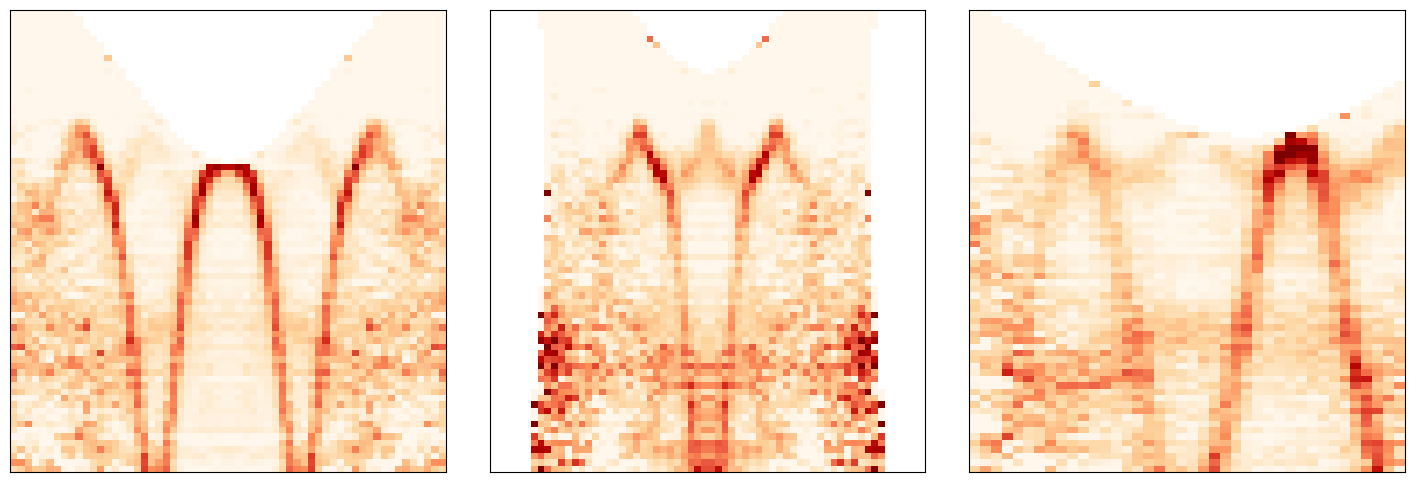

In [24]:
print([str(i) for i in standard_array])
fig, ax = plt.subplots(nrows=1, ncols=Qpaths_num, figsize=(6*Qpaths_num,6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})

if Qpaths_num == 1:
    ax.imshow(ori_res[i], aspect=0.6, vmax=0.04, cmap='OrRd')
    ax.set_xticks([])
    ax.set_yticks([])
else:
    for i in range(Qpaths_num):
        ax[i].imshow(np.flipud(ori_res[i][15:,:]), aspect='auto', vmin=0, vmax=0.0001, cmap='OrRd')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
plt.show()

['-1.9034', '-3.3792', '-1.6698', '-0.0933', '-0.0896', '0.21', '0.3665', '-0.2932', '0.31', '3.0']


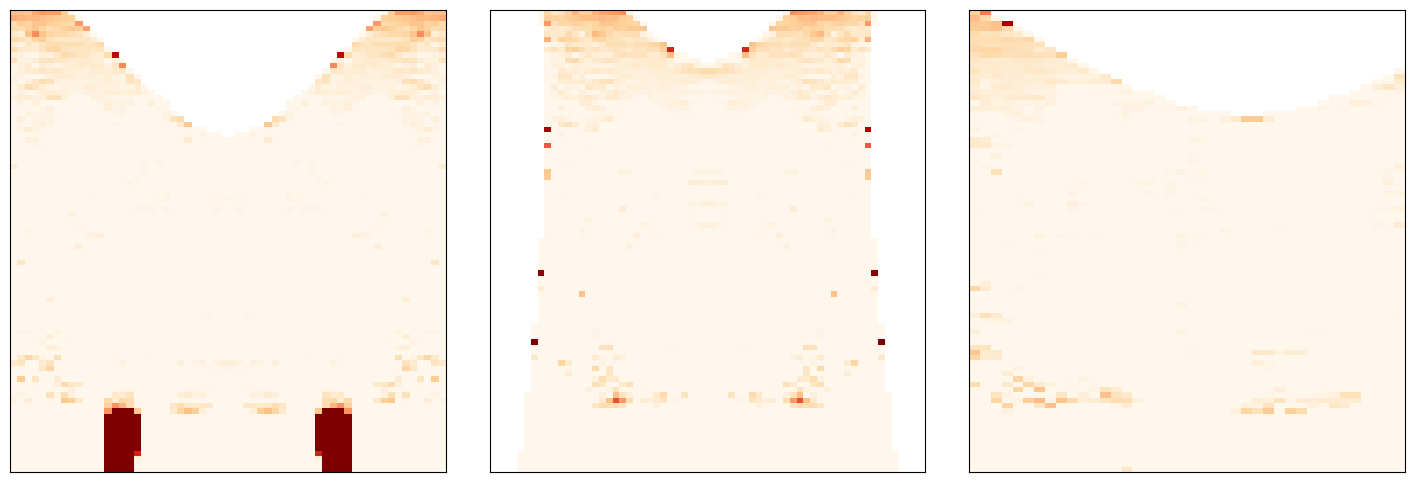

In [3]:
## minus plot

print([str(i) for i in standard_array])
fig, ax = plt.subplots(nrows=1, ncols=Qpaths_num, figsize=(6*Qpaths_num,6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})

if Qpaths_num == 1:
    ax.imshow(-ori_res[i], aspect=0.6, vmax=0.04, cmap='OrRd')
    ax.set_xticks([])
    ax.set_yticks([])
else:
    for i in range(Qpaths_num):
        ax[i].imshow(np.flipud(-ori_res[i]), aspect='auto', vmin=0, vmax=0.0001, cmap='OrRd')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
plt.show()

In [4]:
class IO(object):
    
    def __init__(self, root_path, expr_num, experiment=Expr, img_shape=img_shape, output_file_name='out.pickle', sample_file='SW_point.txt'):

        # simulation Q and E for SpinW Simulation

        print(f"expr_num:{expr_num}")
        Expr = experiment[expr_num]
        Q_paths = [Expr['Exp_Kgrid'][0][0], Expr['Exp_Kgrid'][0][1], img_shape[1]] 
        E_grid = [Expr['Exp_Egrid'][0], Expr['Exp_Egrid'][1], img_shape[0]]
        
        # Experiment Q and E
        Exp_Q_paths = Expr['Exp_Kgrid'][0]
        Exp_E_paths = Expr['Exp_Egrid']
        
        self.root_path = root_path
        self.expr_num = expr_num
        self.experiment = Expr
        self.K = Expr['Exp_Kgrid'][1]
        self.simu_Q = Q_paths
        self.simu_E = E_grid
        self.expr_Q = Exp_Q_paths
        self.expr_E = Exp_E_paths
        self.output_file_name = output_file_name
        self.sample_file = sample_file

    def read_output(self, folder):

        with open(f'{self.root_path}{folder}/{self.output_file_name}', 'rb') as file:
            para, sw = pickle.load(file)

        return para, sw

    def read_experimet(self):
        
        expfile = f"{root_path}files/data/{self.experiment['Exp_info'][0]}"
        MO = mantidOutput(expfile)

        return MO.II

    def read_SW(self):
        
        with open(f'{self.root_path}{self.expr_num}_{self.sample_file}', 'r') as f:
            SWl = f.readlines()
        
        X = []
        Y = []
        itercount = []
        for num,i in enumerate(SWl):
            info = i.split()
            _x = [float(info[0]), float(info[1])]
            X.append(_x)
            Y.append(float(info[2]))
            if int(info[3])==0:
                itercount.append(num)

        norm_X = np.array(X)
        norm_Y = np.array(Y)

        return [norm_X, norm_Y, itercount]
    
    def data_index_transformation(self, data, direction='expdata_2_simuindex'):
        '''Currently only serves for index transformation to (0,500) and (0,300)'''
        '''The index range is changing with the Quanty input settings'''
        '''input 2*N --> output 2*N'''
        '''data type numpy N*2 matrix [(x0_1,x0_2), (x1_1,x1_2), ...]''' 
        '''data format: [Energy, K]'''
        
        if type(data)!=np.ndarray:
            data = np.array(data)
            
        if len(data.shape) < 2:
            data = np.expand_dims(data, axis=0)
            
        new_array = np.zeros(data.shape)

        ### for Hamiltonian fitting, to get simu_index from experiment [Energy, Q]
        if direction == 'expdata_2_simuindex':     
            assert (self.simu_E[0] <= data[:,0]).all() and (data[:,0] <= self.simu_E[1]).all()
            assert (-self.K <= data[:,1]).all() and (data[:,1] <= self.K).all()
            
            # 1. Exp energy to simu index and Exp Kgrid to simu index
            energy_to_simu_index = (data[:,0]-self.simu_E[0])/(self.simu_E[1]-self.simu_E[0])*self.simu_E[2]
            Q_to_simu_index = (data[:,1]-(-self.K))/(self.K-(-self.K))*self.simu_Q[2]
            
            new_array[:,0] = np.array([np.around(i, 0) for i in energy_to_simu_index])
            new_array[:,1] = np.array([np.around(i, 0) for i in Q_to_simu_index])
            
        ### for sampling [energy, K], to get experiment [Energy, Q] from simu_index
        elif direction == 'simuindex_2_expdata':
            assert (data[:,0] <= self.simu_E[2]).all() and (data[:,1] <= self.simu_Q[2]).all()
            
            # 2. simu index to Exp energy and simu index to Exp Kgrid
            simu_index_to_energy = (data[:,0]/self.simu_E[2])*(self.simu_E[1]-self.simu_E[0])+self.simu_E[0]
            simu_index_to_Q = (data[:,1]/self.simu_Q[2])*(self.K-(-self.K))-self.K

            new_array[:,0] = simu_index_to_energy
            new_array[:,1] = simu_index_to_Q

        ### for mimic the experiment measurement, may be deprecated in furture version when access to real experimental test
        elif direction == 'expdata_2_expindex':
            assert (self.expr_E[0] <= data[:,0]).all() and (data[:,0] <= self.expr_E[1]).all()
            assert (-self.K <= data[:,1]).all() and (data[:,1] <= self.K).all()

            # 3. Exp energy to Exp index and Exp Kgrid to Exp index
            energy_to_expr_index = (data[:,0]-self.expr_E[0])/(self.expr_E[1]-self.expr_E[0])*self.expr_E[2]
            Q_to_expr_index = (data[:,1]-(-self.K))/(self.K-(-self.K))*self.expr_Q[2]
            
            new_array[:,0] = np.array([np.around(i, 0) for i in energy_to_expr_index])
            new_array[:,1] = np.array([np.around(i, 0) for i in Q_to_expr_index])

        elif direction == 'expindex_2_expdata':
            assert (data[:,0] <= self.expr_E[2]).all() and (data[:,1] <= self.expr_Q[2]).all()
            
            # 2. Exp index to Exp energy and Exp index to Exp Kgrid
            expr_index_to_energy = (data[:,0]/self.expr_E[2])*(self.expr_E[1]-self.expr_E[0])+self.expr_E[0]
            expr_index_to_Q = (data[:,1]/self.expr_Q[2])*(self.K-(-self.K))-self.K

            new_array[:,0] = expr_index_to_energy
            new_array[:,1] = expr_index_to_Q

        return new_array


In [15]:
print(MO.XX)
print(len(MO.XX))

#print(RIXS.shape[1],io.simu_Q[2]-1)
RIXS_Q = ((np.arange(RIXS.shape[1])/(io.simu_Q[2]-1))*(io.K-(-io.K))-io.K)
# print(RIXS_Q.shape)

[-0.975      -0.925      -0.875      -0.825      -0.7749999  -0.7249999
 -0.6749999  -0.6249999  -0.5749999  -0.5249999  -0.4749999  -0.4249999
 -0.3749999  -0.3249998  -0.2749998  -0.2249998  -0.1749998  -0.1249998
 -0.07499978 -0.02499977  0.02500024  0.07500026  0.1250003   0.1750003
  0.2250003   0.2750003   0.3250003   0.3750003   0.4250003   0.4750004
  0.5250004   0.5750004   0.6250004   0.6750004   0.7250004   0.7750004
  0.8250004   0.8750004   0.9250005   0.9750005 ]
40


1
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


/tmp/ipykernel_2273140/3840269922.py:145: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


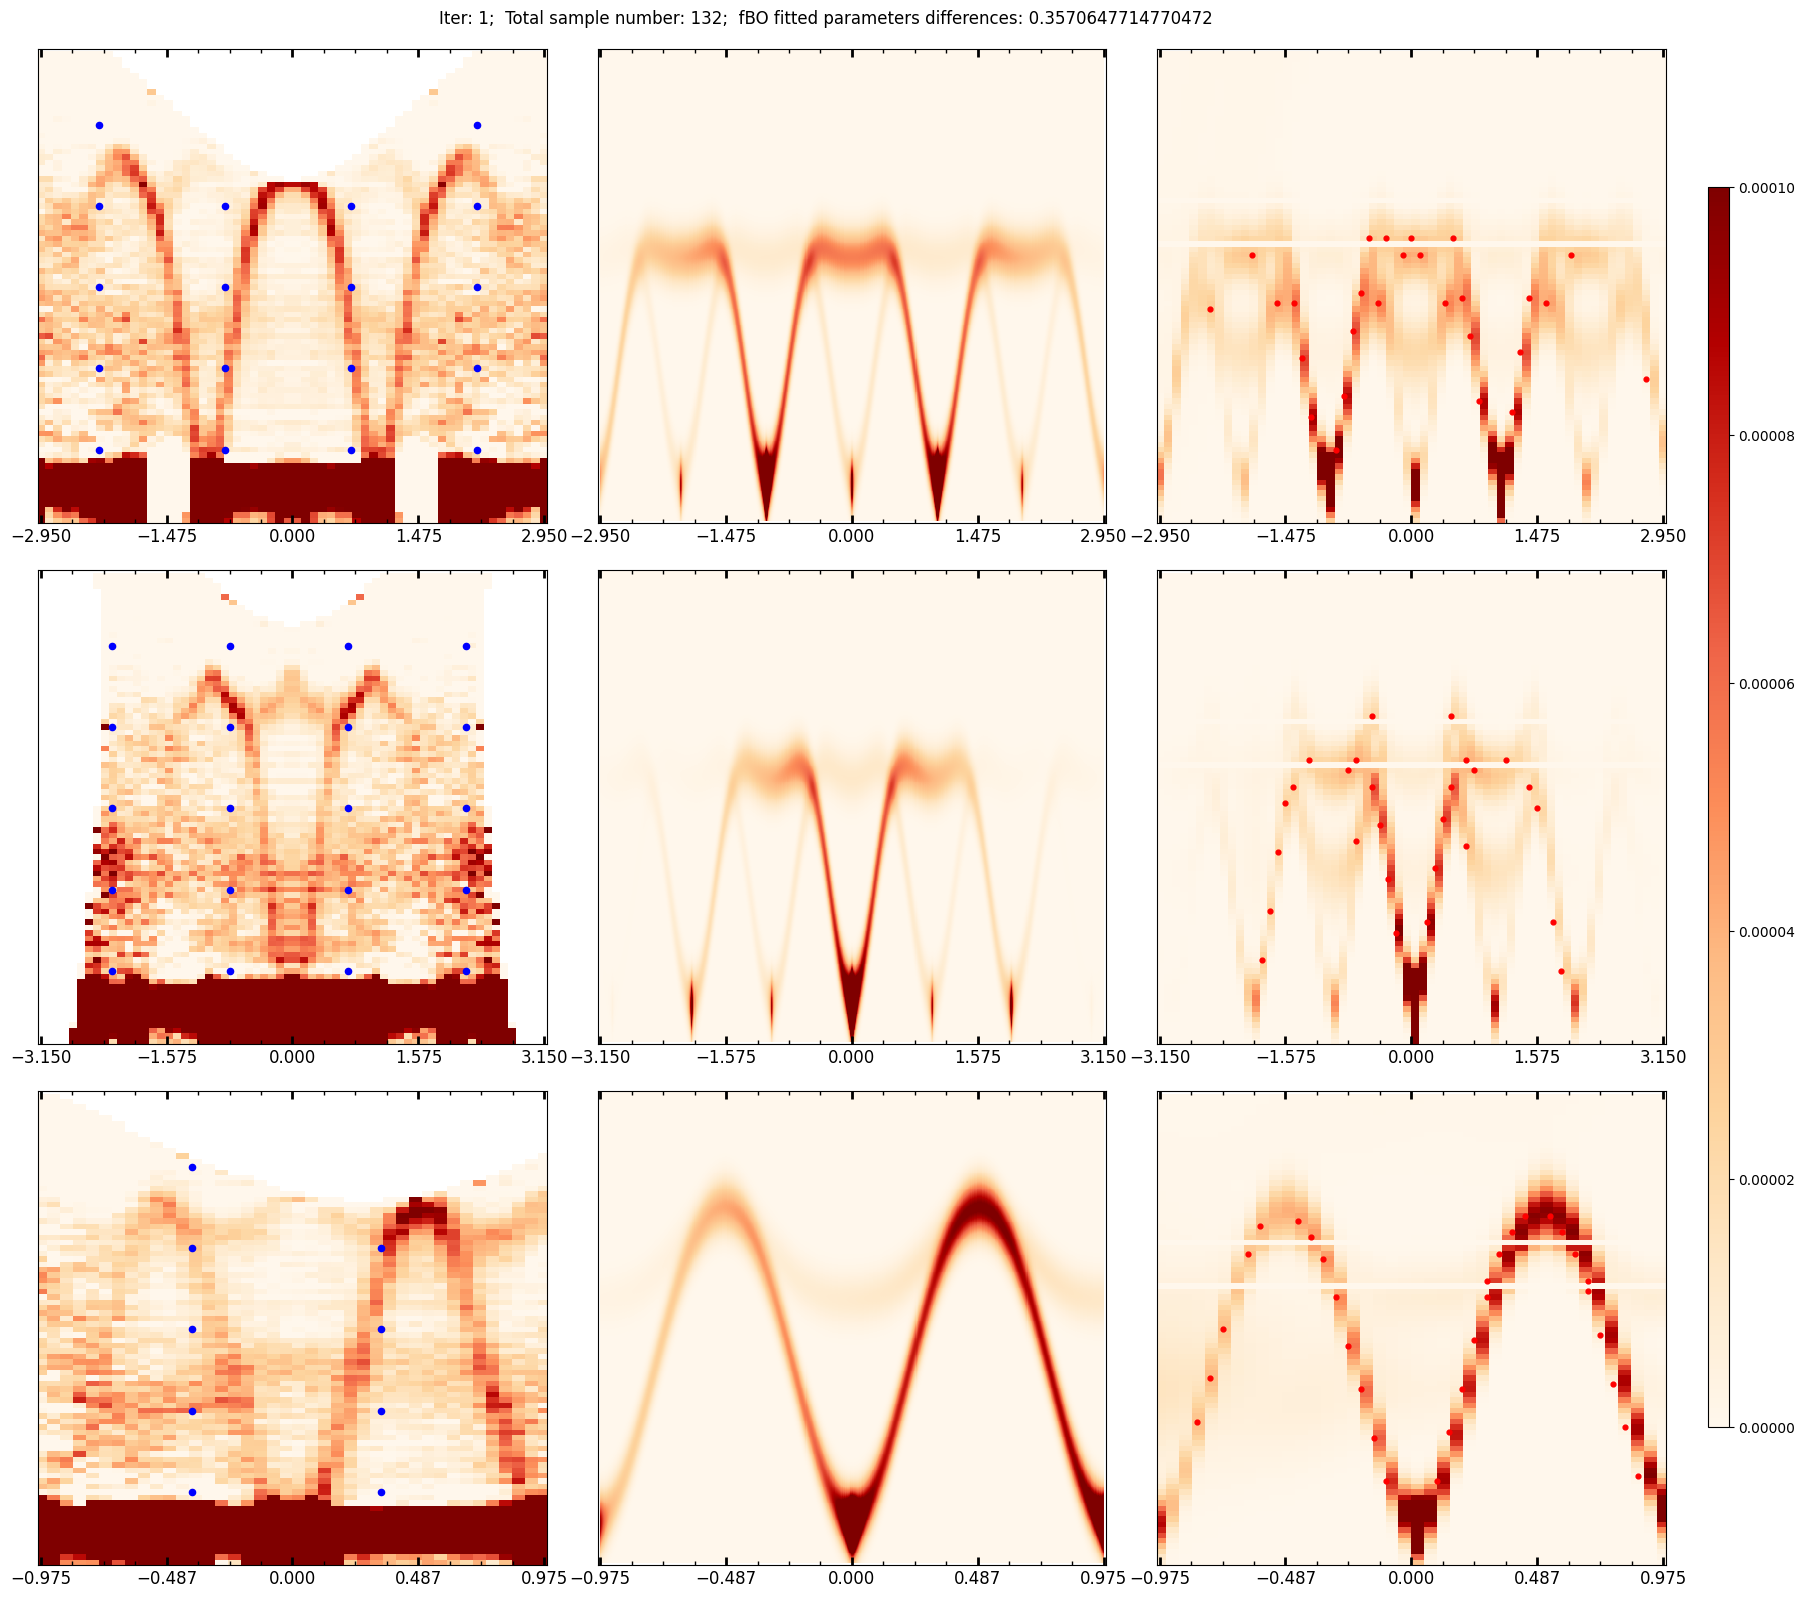

2
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


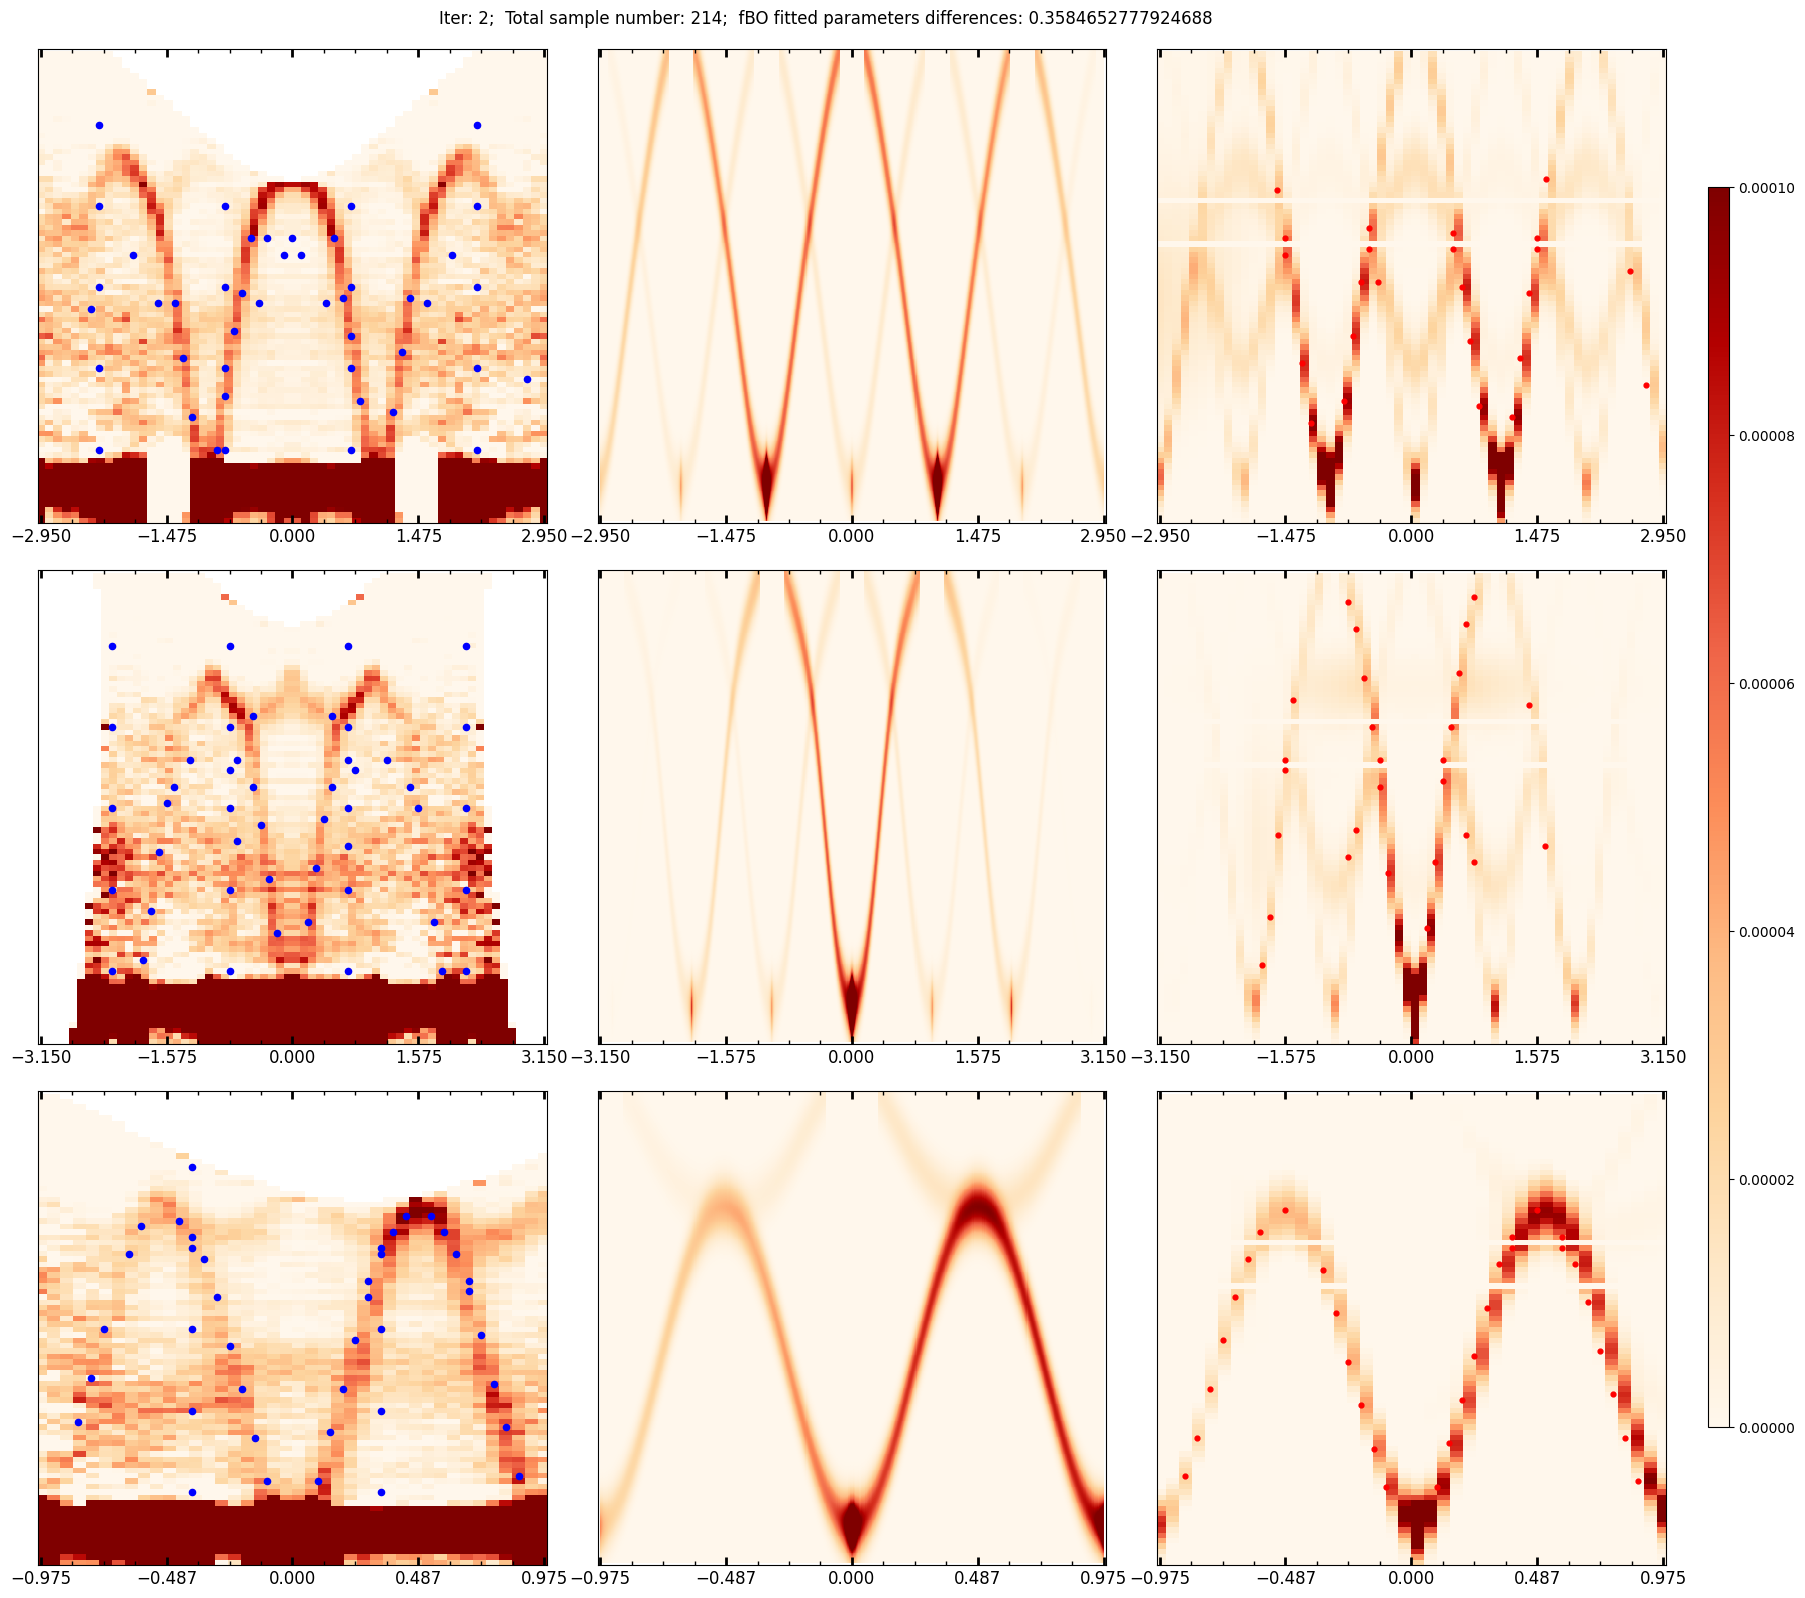

3
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


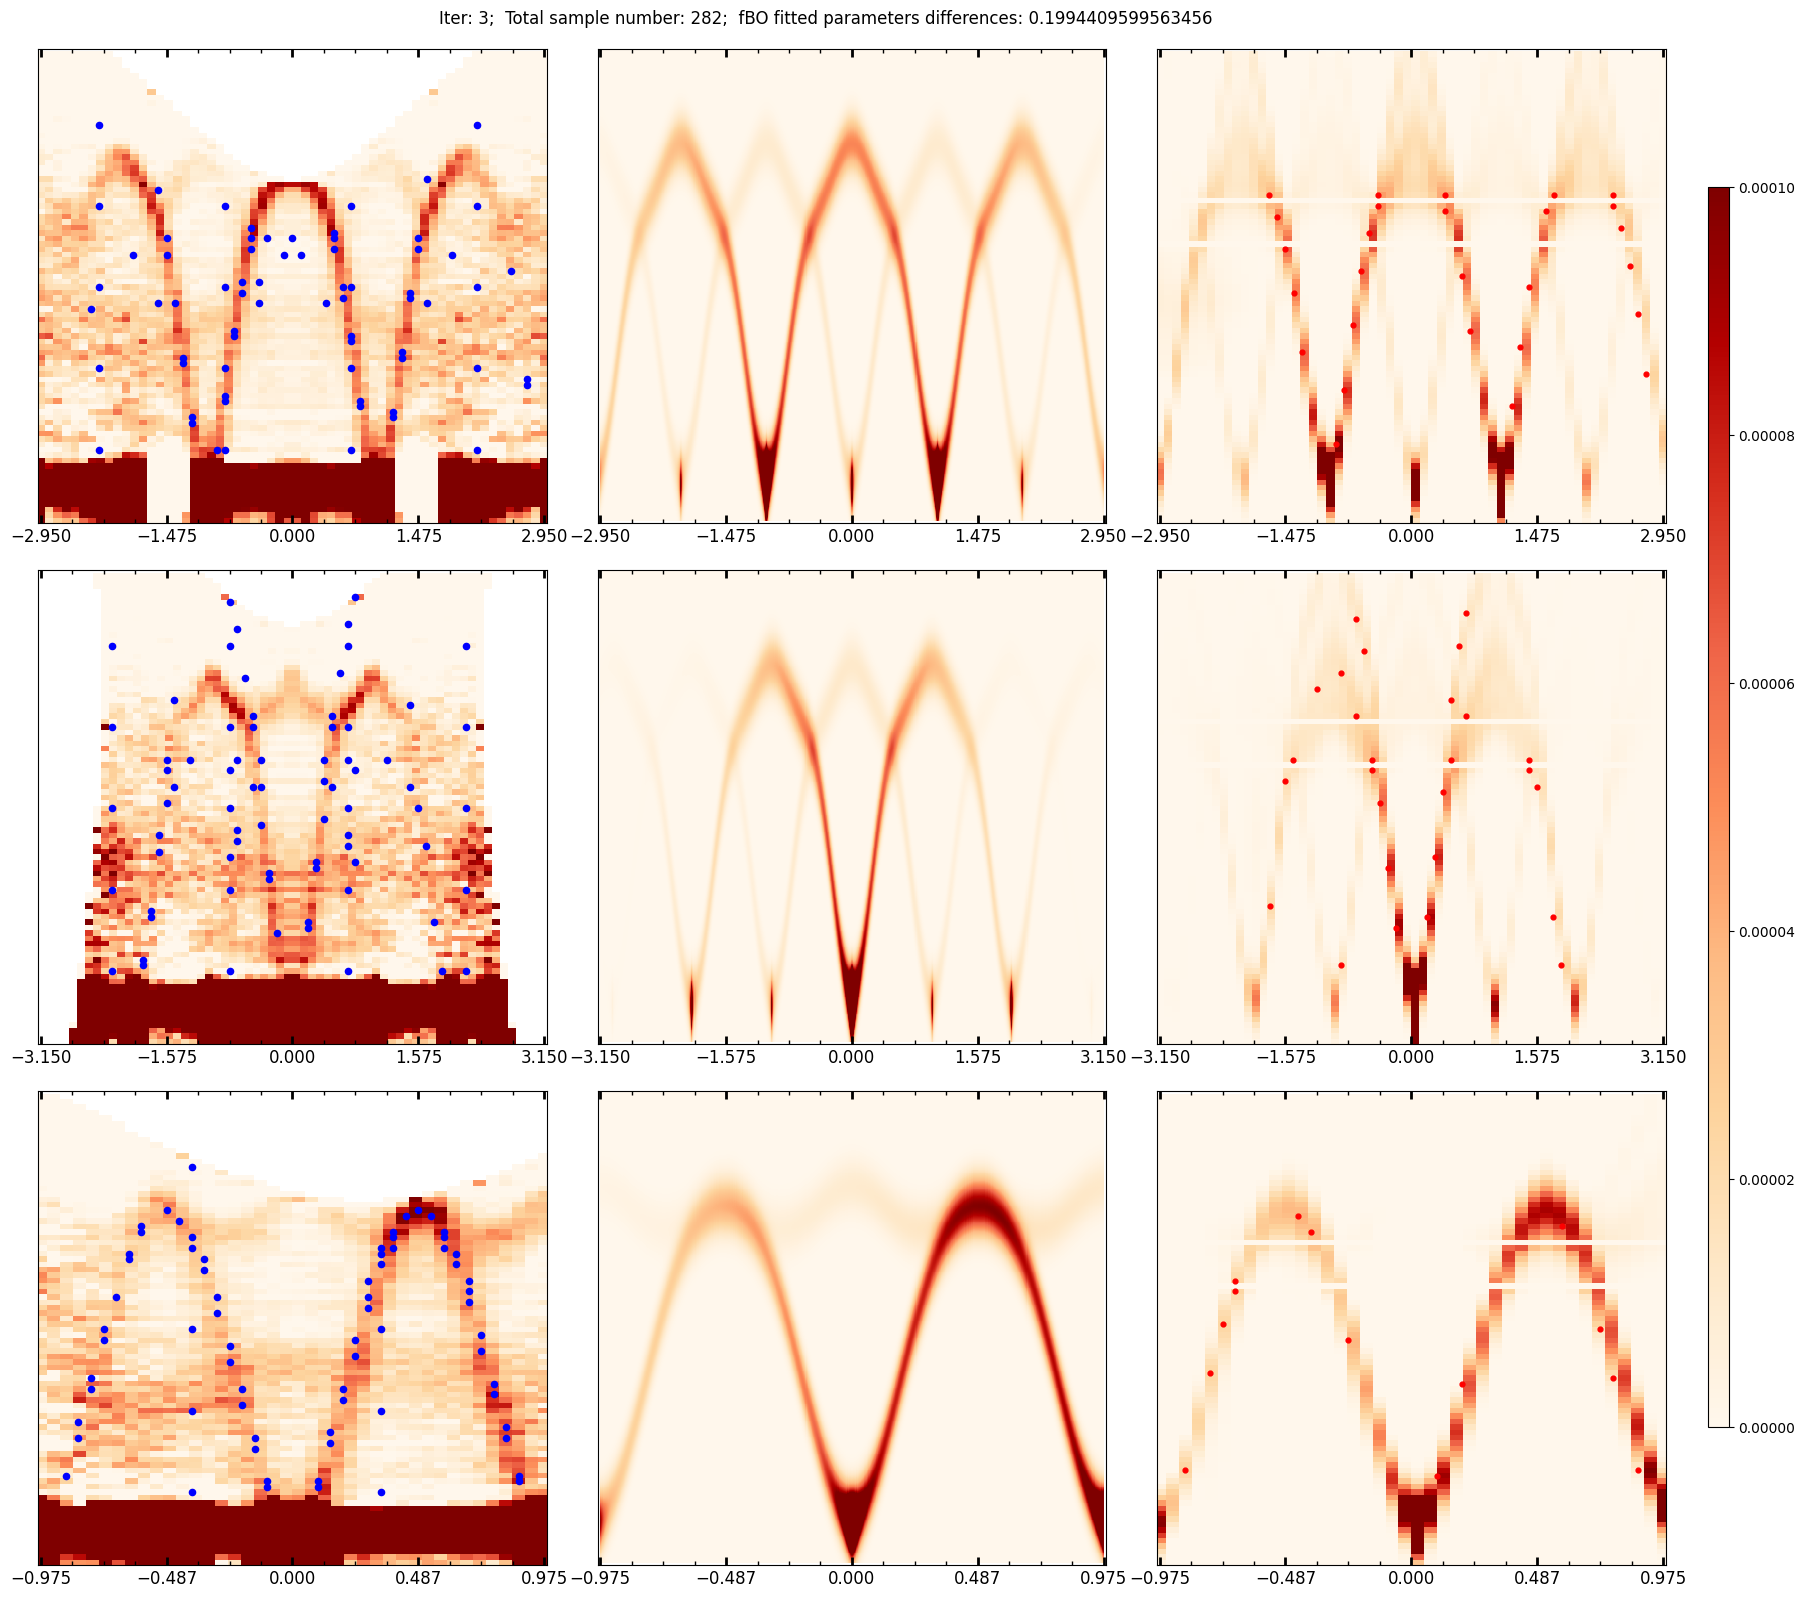

4
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


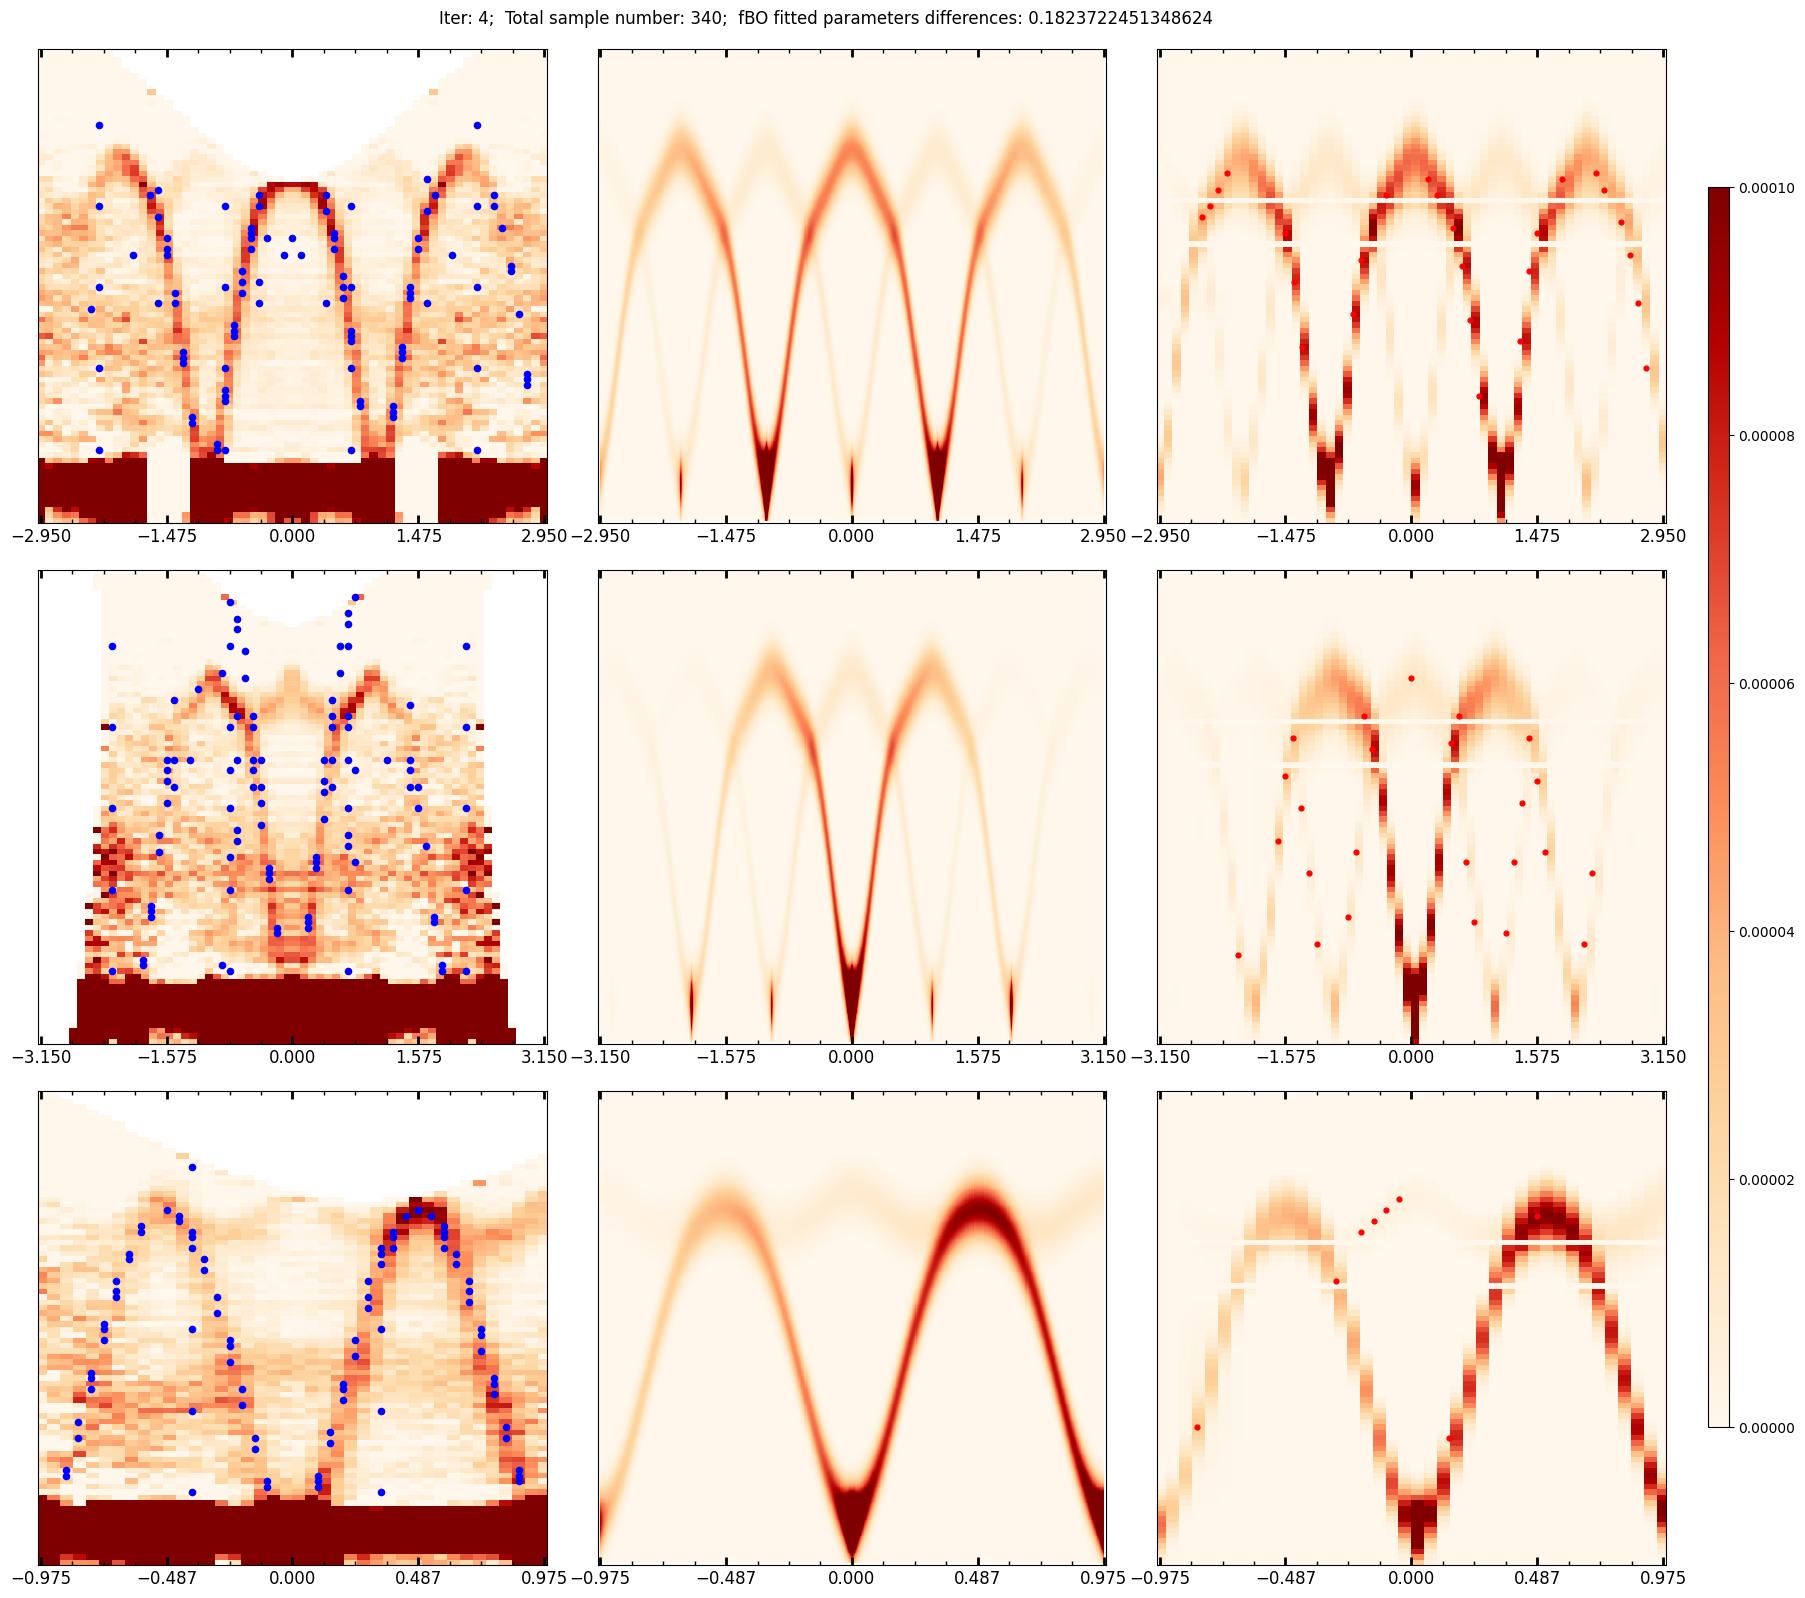

5
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


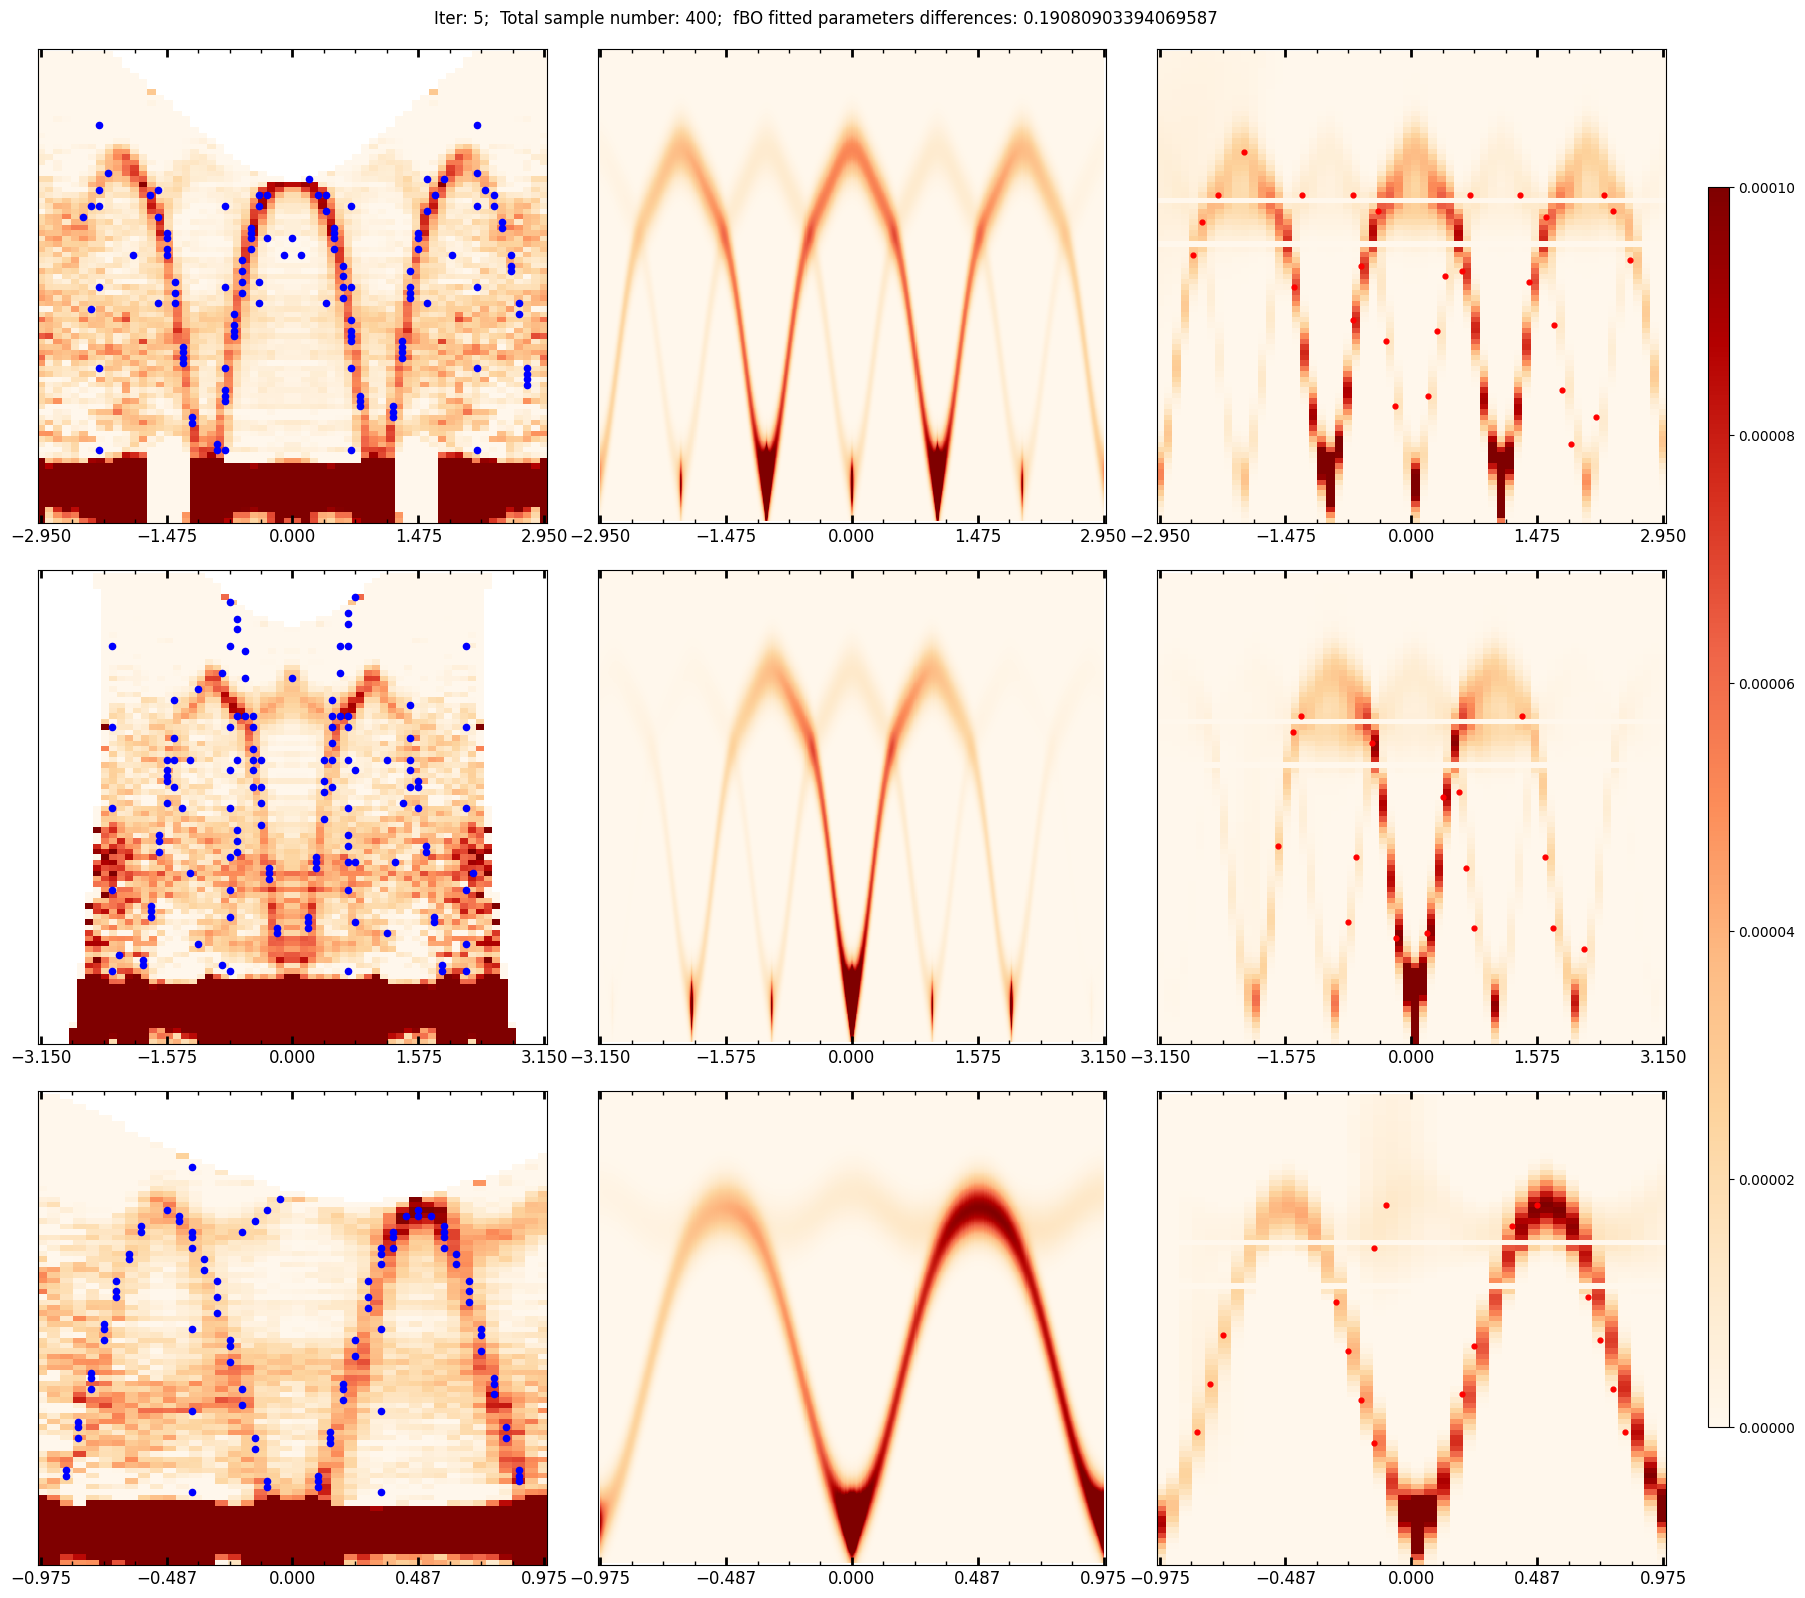

6
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


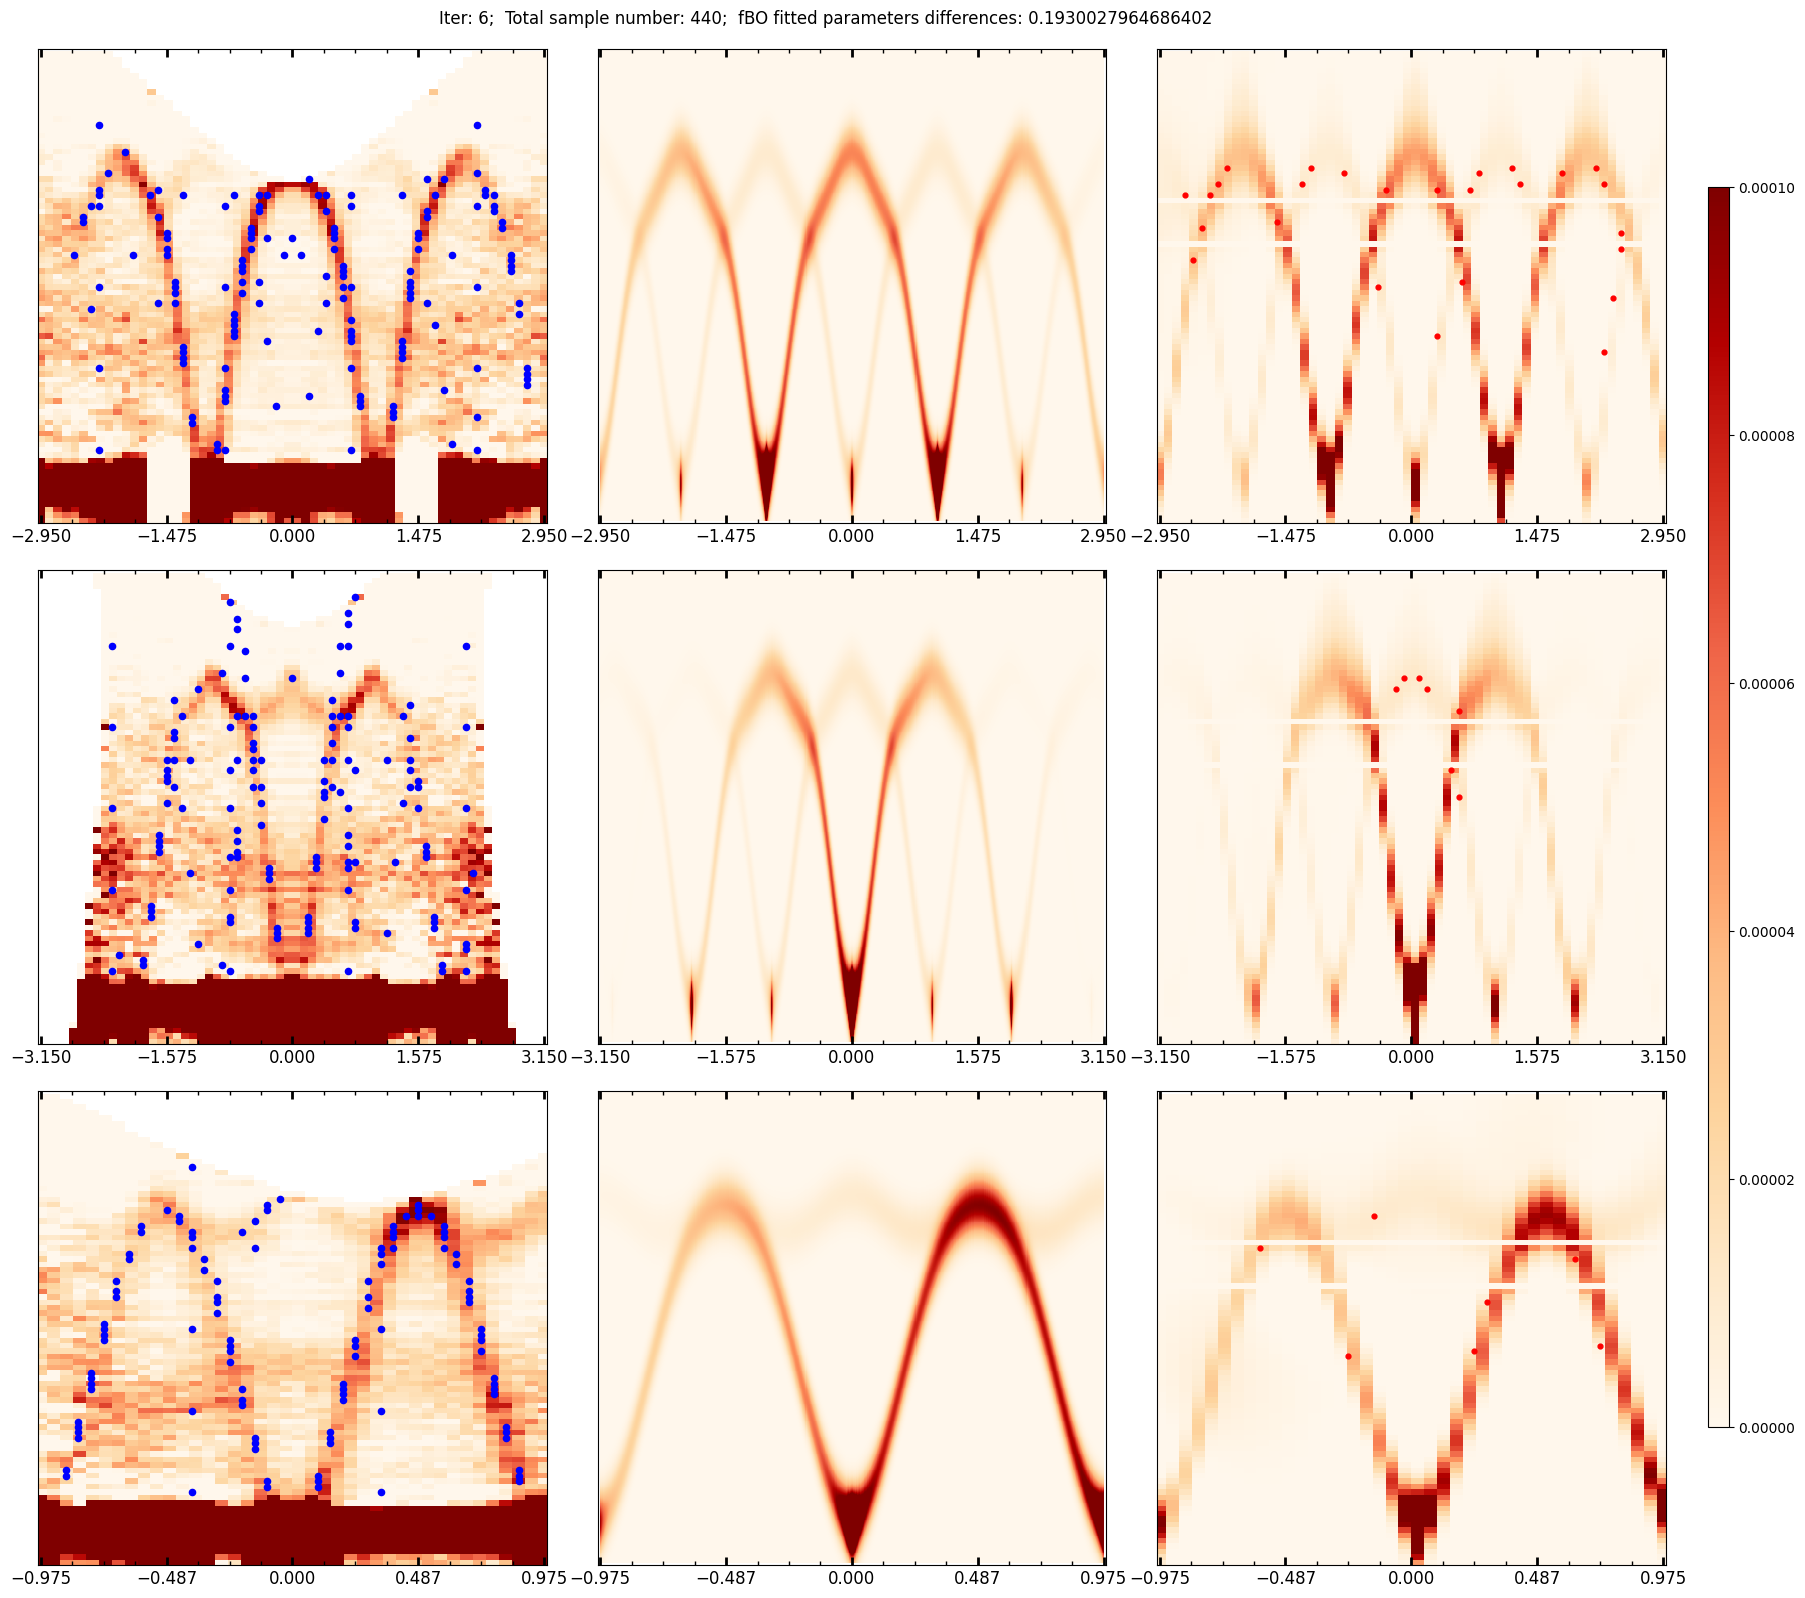

7
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


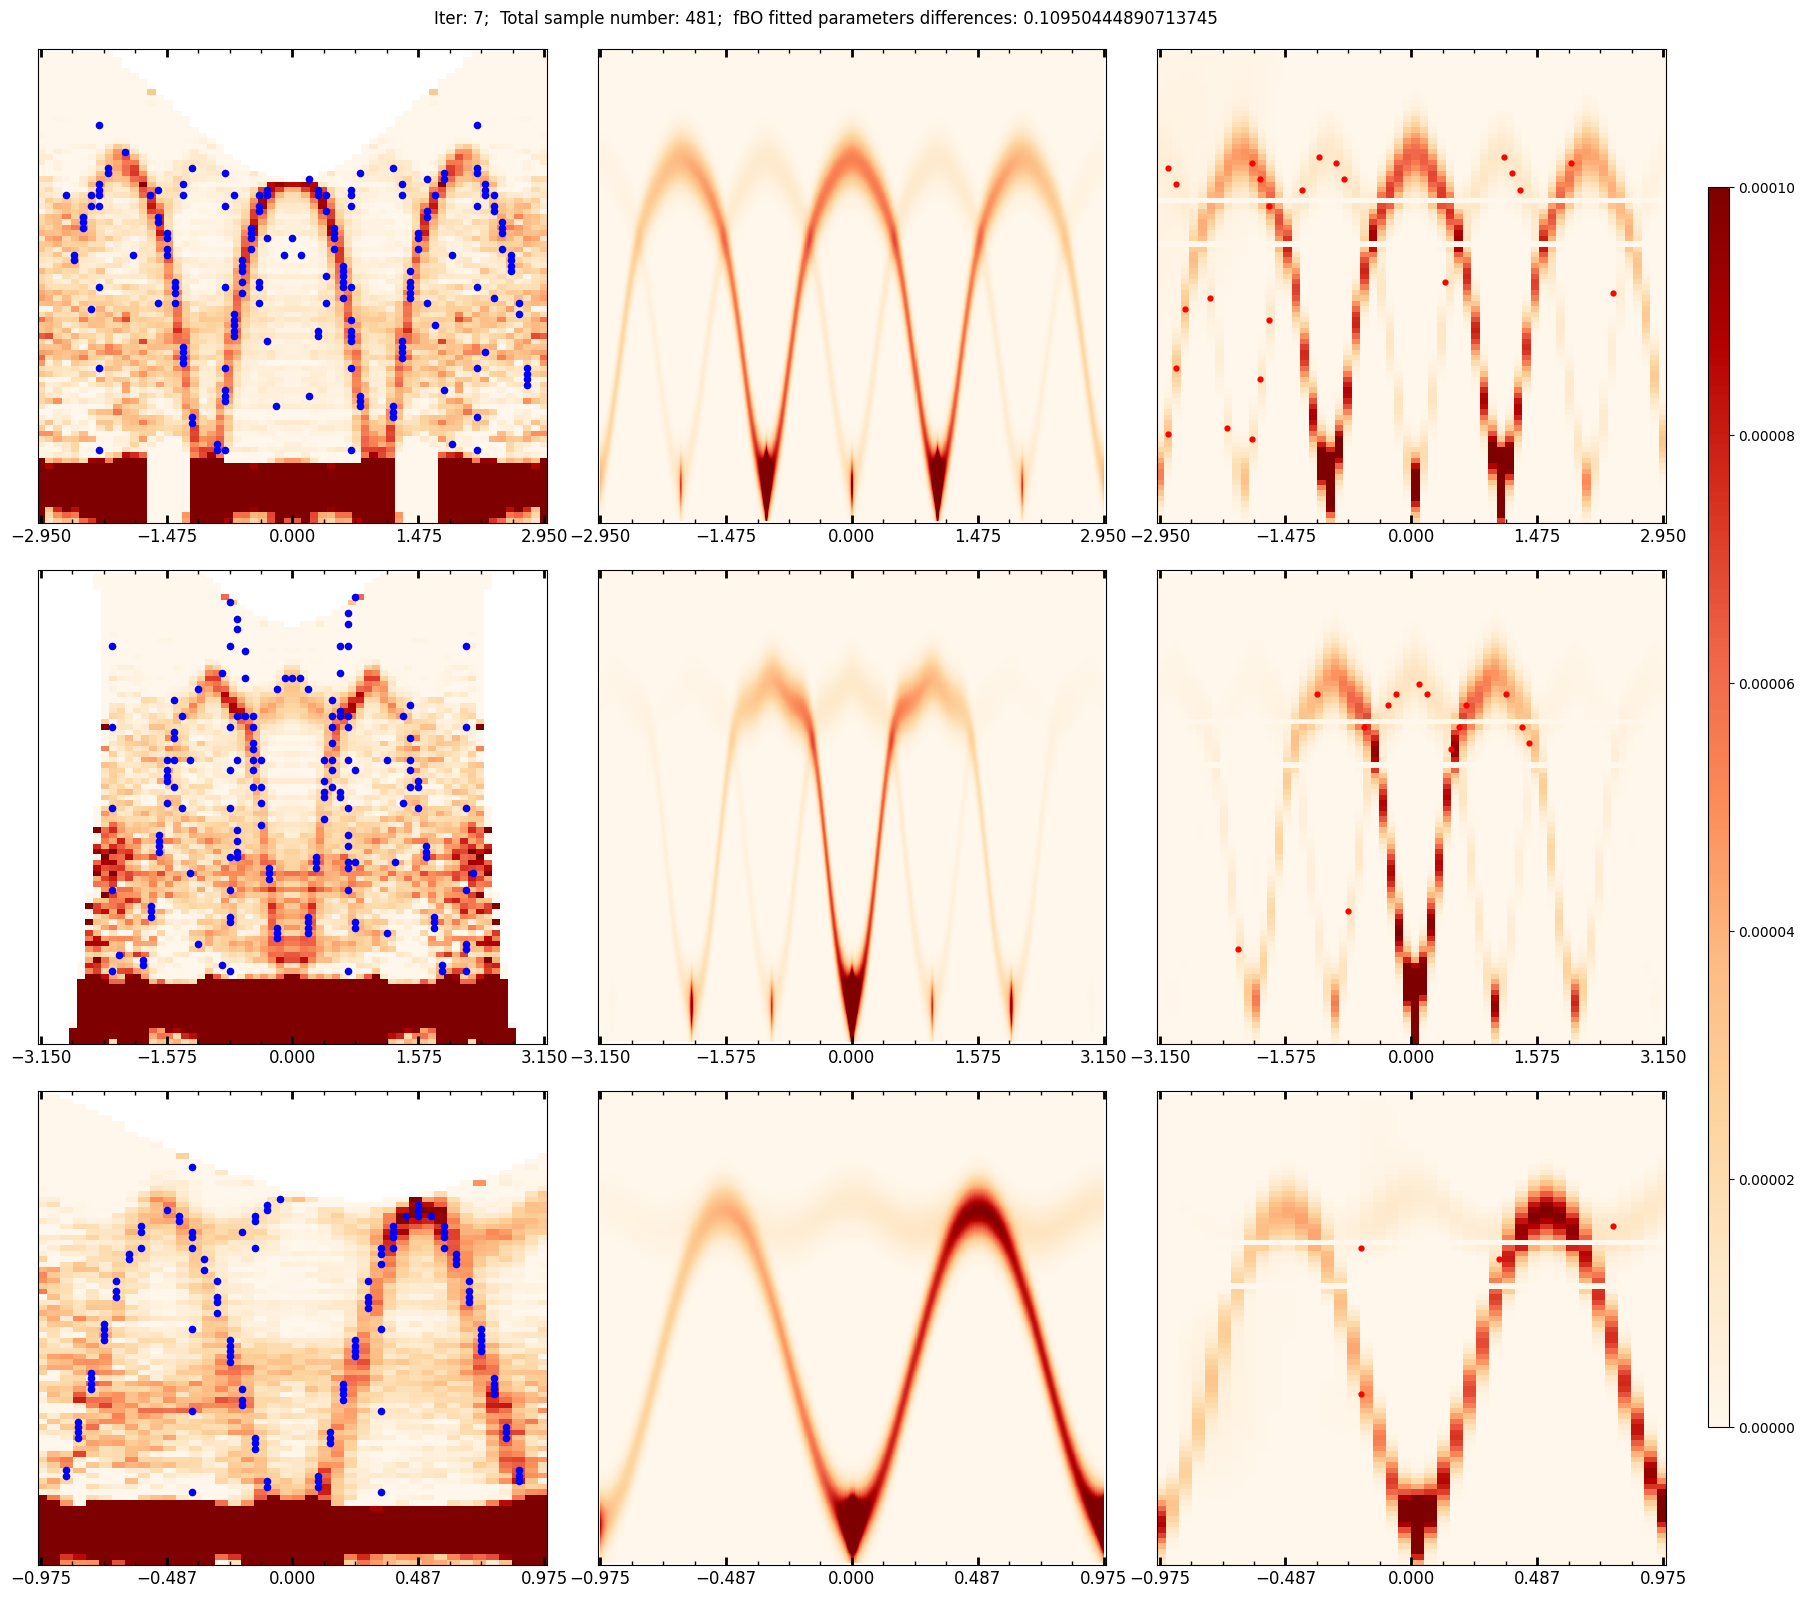

8
expr_num:0
-2.95 2.95
2.95 2.95 2.95 2.95
(87, 60)
expr_num:1
-3.15 3.15
3.15 3.15 3.15 3.15
(87, 64)
expr_num:2
-0.975 0.975
0.975 0.975 0.975 0.975
(87, 40)


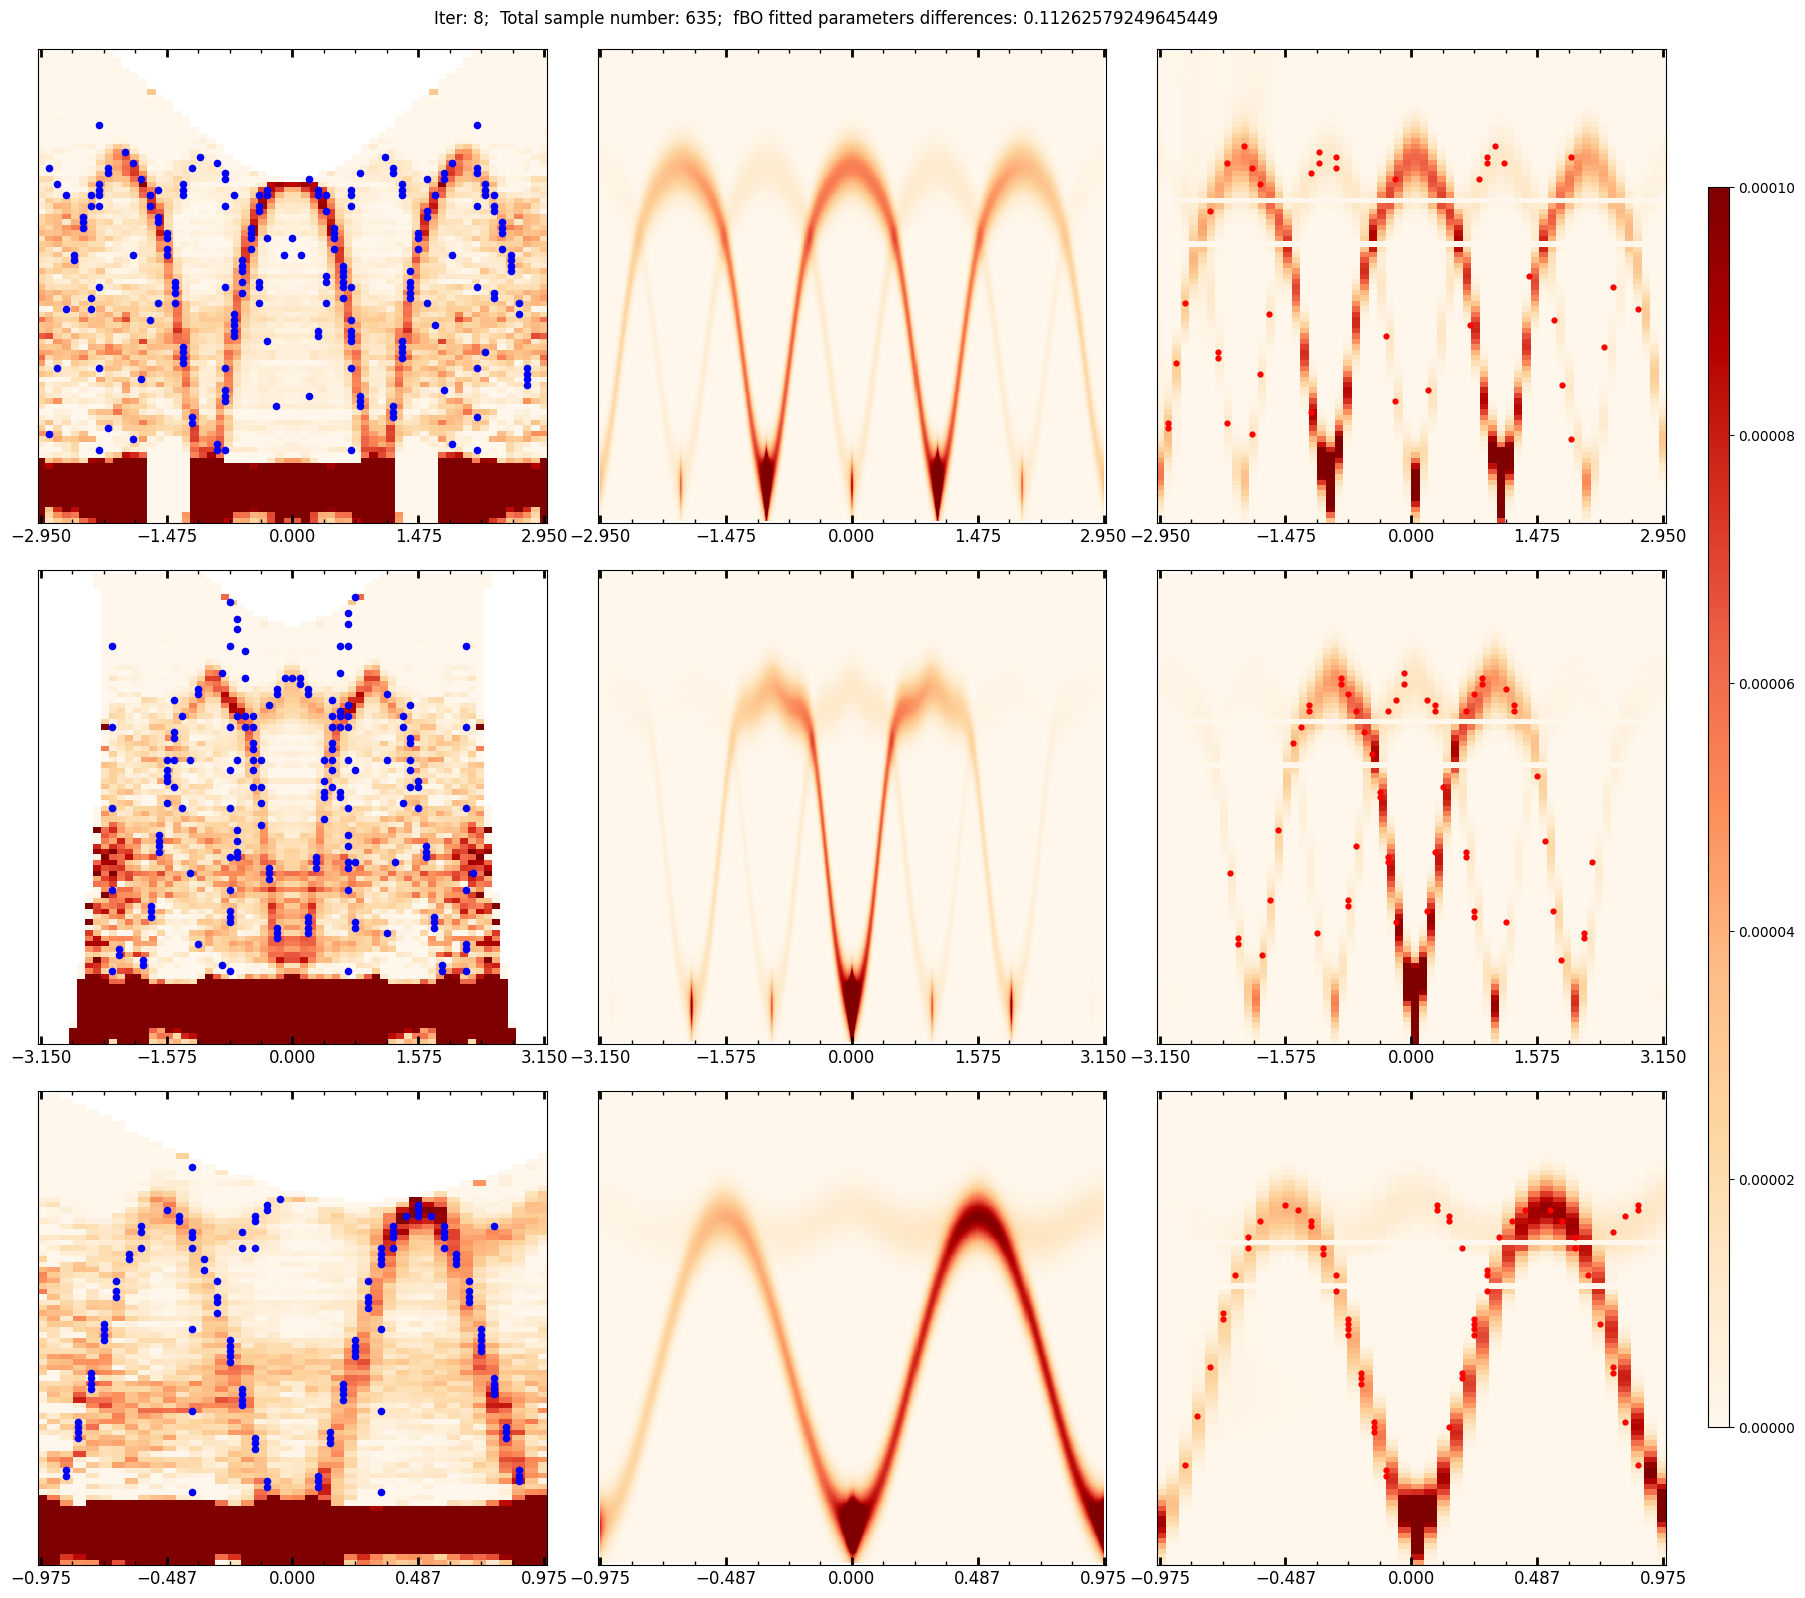

In [28]:
root = os.getcwd()+'/'
t_name = root.split('/')[-2]
#root = f'/work/projects/p0020541/Yixuan/SpinWave/{t_name}/'
#number = min(int(os.popen(f'cat {root}para_results.txt | wc -l').read()),10)
number = int(os.popen(f'cat {root}para_results.txt | wc -l').read())
cmap = 'OrRd'
dev = 0

images = []
#for num in range(7, 9):
for num in range(1, number-dev+1):

    print(num)
    
    fig, ax = plt.subplots(nrows=Qpaths_num, ncols=3, figsize=(21, 21/3.2*Qpaths_num), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.1})

    final_max = 0.0001
    total_sample_num = 0
    sample_max = []
    total_diff = []
    
    for i in range(Qpaths_num):

        io = IO(root, i)

        samples = io.read_SW()
        sampling_num = samples[2][num+1] if num<number-dev else len(samples[1])
        sample_max.append(np.max(samples[1][:sampling_num]))
        total_sample_num += sampling_num
        
        para, _RIXS = io.read_output(f'parameters/{num+dev}')
        RIXS = _RIXS[i]
        # print(RIXS.shape)
        RIXS_energy = (np.arange(RIXS.shape[0])/io.simu_E[2])*(io.simu_E[1]-io.simu_E[0])+io.simu_E[0]
        RIXS_Q = ((np.arange(RIXS.shape[1])/(io.simu_Q[2]-1))*(io.K-(-io.K))-io.K)

        #print(RIXS_energy.shape, RIXS_Q.shape)
        
        ori = io.read_experimet()
        #print(ori.shape)
        ori_energy = (np.arange(ori.shape[0])/io.expr_E[2])*(io.expr_E[1]-io.expr_E[0])+io.expr_E[0]
        ori_Q = ((np.arange(ori.shape[1])/(io.expr_Q[2]-1))*(io.K-(-io.K))-io.K)
        print(min(ori_Q), max(ori_Q))
        #print(ori_energy.shape, ori_Q.shape)
        
        
        #para_diff = np.mean(np.abs(para-standard_array)/np.abs(standard_array))
        para_diff = np.mean(np.abs(para[:-1]-standard_array[:-1]))

        tr = min(max(RIXS_Q), abs(min(RIXS_Q)), max(ori_Q), abs(min(ori_Q)))
        print(max(RIXS_Q), abs(min(RIXS_Q)), max(ori_Q), abs(min(ori_Q)))

        #diff = abs(RIXS-ori)
        #total_diff.append(diff)

        #im = ax[i][1].imshow(ori, aspect='auto', vmin=0, vmax=final_max, cmap='OrRd')
        ax[i][0].tick_params(top=True, labeltop=False, bottom=True, labelbottom=True, labelsize=12)
        # Enable minor ticks
        ax[i][0].minorticks_on()
        # Set major and minor tick parameters for both axes
        ax[i][0].tick_params(axis="both", which="major", direction="in", width=2, length=6)
        ax[i][0].tick_params(axis="both", which="minor", direction="in", width=1, length=3)
        # Calculate the interval for major and minor ticks
        major_interval = (2*tr) / 4  # 4 segments, so 5 ticks total
        minor_interval = major_interval / 4  # 3 minor ticks between each major tick (4 segments)
        major_ticks = np.linspace(-tr, tr, 5)
        ax[i][0].set_xticks(major_ticks, minor=False)
        # Set minor ticks
        ax[i][0].xaxis.set_minor_locator(MultipleLocator(minor_interval))
        ax[i][0].tick_params(axis="x", which="minor", top=True, bottom=True)

        im = ax[i][0].pcolormesh(ori_Q, ori_energy, ori, vmin=0, vmax=final_max, cmap=cmap)
        # exp_samples =  io.data_index_transformation(io.data_index_transformation(samples[0], 'expdata_2_simuindex'), 'simuindex_2_expdata')
        # ax[i][0].scatter(exp_samples[:,1][:samples[2][num]], exp_samples[:,0][:samples[2][num]], s=20, c='blue')
        # ax[i][0].scatter(exp_samples[:,1][samples[2][num]:sampling_num], exp_samples[:,0][samples[2][num]:sampling_num], s=20, c='r')
        ax[i][0].scatter(samples[0][:,1][:samples[2][num]], samples[0][:,0][:samples[2][num]], s=20, c='blue')
        #ax[i][0].scatter(samples[0][:,1][samples[2][num]:sampling_num], samples[0][:,0][samples[2][num]:sampling_num], s=20, c='r')
        # ax[i][0].set_xticks([])
        ax[i][0].set_xlim((1+0.01)*-tr, (1+0.01)*tr)
        ax[i][0].set_yticks([])


        
        #ax[i][1].imshow(RIXS, aspect='auto', vmin=0, vmax=final_max, cmap='OrRd')
        ax[i][1].tick_params(top=True, labeltop=False, bottom=True, labelbottom=True, labelsize=12)
        # Enable minor ticks
        ax[i][1].minorticks_on()
        # Set major and minor tick parameters for both axes
        ax[i][1].tick_params(axis="both", which="major", direction="in", width=2, length=6)
        ax[i][1].tick_params(axis="both", which="minor", direction="in", width=1, length=3)
        # Calculate the interval for major and minor ticks
        major_interval = (2*tr) / 4  # 4 segments, so 5 ticks total
        minor_interval = major_interval / 4  # 3 minor ticks between each major tick (4 segments)
        major_ticks = np.linspace(-tr, tr, 5)
        ax[i][1].set_xticks(major_ticks, minor=False)
        # Set minor ticks
        ax[i][1].xaxis.set_minor_locator(MultipleLocator(minor_interval))
        ax[i][1].tick_params(axis="x", which="minor", top=True, bottom=True)
        ax[i][1].pcolormesh(RIXS_Q, RIXS_energy, RIXS, vmin=0, vmax=0.03, cmap=cmap)
        # sim_samples =  io.data_index_transformation(io.data_index_transformation(samples[0], 'expdata_2_expindex'), 'expindex_2_expdata')
        # ax[i][1].scatter(sim_samples[:,1][:samples[2][num]], sim_samples[:,0][:samples[2][num]], s=20, c='blue')
        # ax[i][1].scatter(sim_samples[:,1][samples[2][num]:sampling_num], sim_samples[:,0][samples[2][num]:sampling_num], s=20, c='r')
        # ax[i][1].scatter(samples[0][:,1][:samples[2][num]], samples[0][:,0][:samples[2][num]], s=20, c='blue')
        # ax[i][1].scatter(samples[0][:,1][samples[2][num]:sampling_num], samples[0][:,0][samples[2][num]:sampling_num], s=20, c='red')
        # ax[i][1].set_xticks([])
        ax[i][1].set_xlim((1+0.01)*-tr, (1+0.01)*tr)
        ax[i][1].set_yticks([])


        ax[i][2].tick_params(top=True, labeltop=False, bottom=True, labelbottom=True, labelsize=12)
        # Enable minor ticks
        ax[i][2].minorticks_on()
        # Set major and minor tick parameters for both axes
        ax[i][2].tick_params(axis="both", which="major", direction="in", width=2, length=6)
        ax[i][2].tick_params(axis="both", which="minor", direction="in", width=1, length=3)
        # Calculate the interval for major and minor ticks
        major_interval = (2*tr) / 4  # 4 segments, so 5 ticks total
        minor_interval = major_interval / 4  # 3 minor ticks between each major tick (4 segments)
        major_ticks = np.linspace(-tr, tr, 5)
        ax[i][2].set_xticks(major_ticks, minor=False)
        # Set minor ticks
        ax[i][2].xaxis.set_minor_locator(MultipleLocator(minor_interval))
        ax[i][2].tick_params(axis="x", which="minor", top=True, bottom=True)

        with open(f'{root}/parameters/{num}/{i}_fsample.pickle', 'rb') as f:
            stat_data = pickle.load(f)
            print(stat_data.shape)
        #ax[i][2].imshow(np.flipud(stat_data), aspect='auto', vmax=final_max, cmap='OrRd')
        ax[i][2].pcolormesh(ori_Q, ori_energy, stat_data, vmin=0, vmax=np.max(stat_data[15:,:]), cmap=cmap)
        ax[i][2].scatter(samples[0][:,1][samples[2][num]:sampling_num], samples[0][:,0][samples[2][num]:sampling_num], s=12, c='r')
        ax[i][2].set_xlim((1+0.01)*-tr, (1+0.01)*tr)
        ax[i][2].set_yticks([])
    
    cbar_ax = fig.add_axes([0.92, 0.18, 0.01, 0.63])  # 这里的数字分别代表[left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    # fig.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05)
    # cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.04)
    
    #label = f'Iter: {num};   Sample points: {total_sample_num};   Max SP: {np.max(sample_max):.2f};   Mean and Std fitting different: {np.mean(total_diff):.7f}, {np.std(total_diff):.7f};   Parameters_diff: {para_diff*100:.2f}%'
    #label = f'Iter: {num};   Sample points: {total_sample_num};   Max SP: {np.max(sample_max):.2f};  Parameters_diff: {para_diff*100:.2f}%'
    label = f'Iter: {num};  Total sample number: {total_sample_num};  fBO fitted parameters differences: {para_diff}'
    fig.suptitle(label, fontsize=12, y=0.9)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(Image.fromarray(image))
    plt.savefig(f'{num}.png', dpi=300, bbox_inches='tight')
    
    plt.show()

images[0].save(f'SPINW.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)

/work/projects/p0020541/Yixuan/SpinWave/Experment_test_all_para


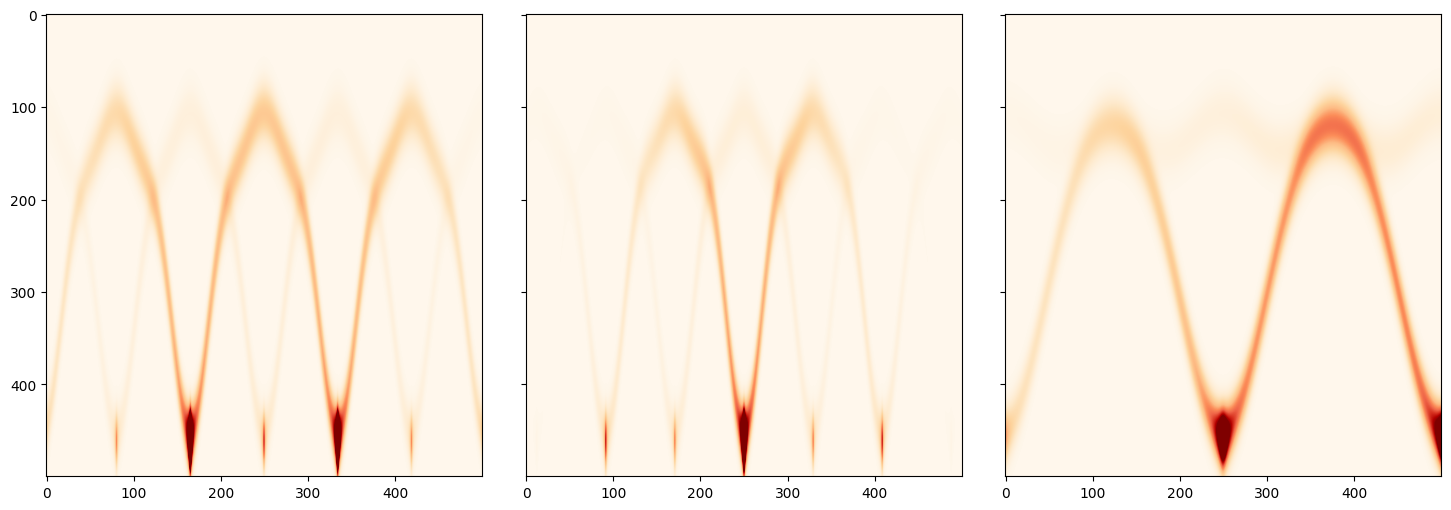

In [10]:
path = os.getcwd()
print(path)
with open(f'{path}/parameters/{num}/stat_model.pickle', 'rb') as file:
    p_res = pickle.load(file)
    
fig, ax = plt.subplots(nrows=1, ncols=Qpaths_num, figsize=(6*Qpaths_num,6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})

if Qpaths_num == 1:
    ax.imshow(p_res[i][0], aspect=0.6, cmap='OrRd')
    ax.set_xticks([])
    ax.set_yticks([])
else:
    for i in range(Qpaths_num):
        ax[i].imshow(np.flipud(p_res[i][0]), aspect='auto', vmin=0, vmax=0.05, cmap='OrRd')
        # ax[i].set_xticks([])
        # ax[i].set_yticks([])
plt.show()

/work/projects/p0020541/Yixuan/SpinWave/Experment_test_all_para


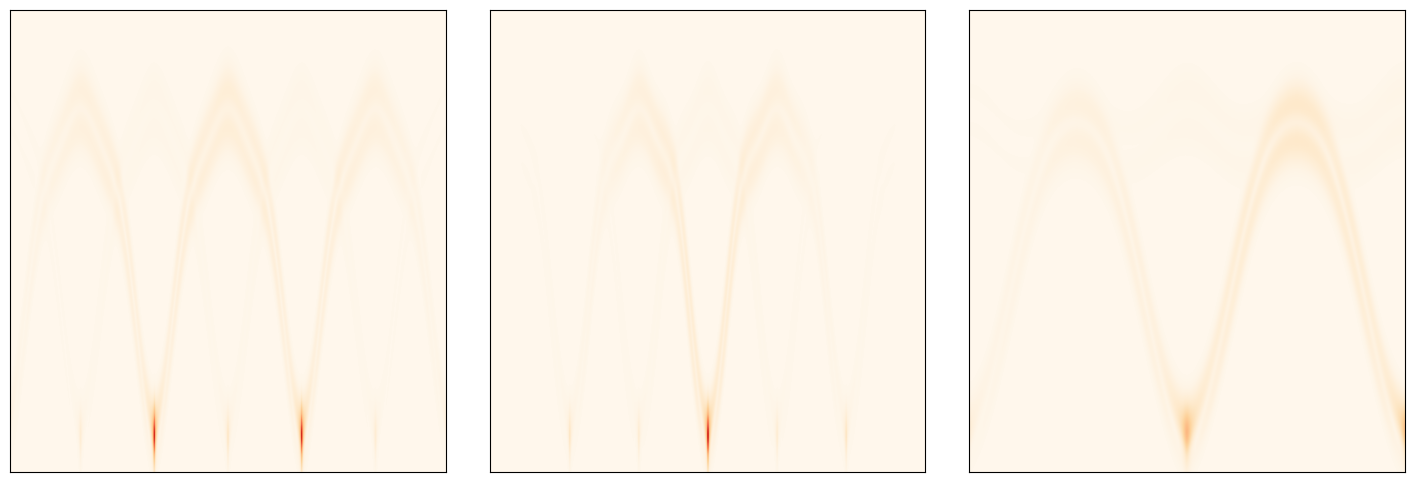

In [13]:
path = os.getcwd()
print(path)
with open(f'{path}/parameters/{num}/stat_model.pickle', 'rb') as file:
    p_res = pickle.load(file)
    
fig, ax = plt.subplots(nrows=1, ncols=Qpaths_num, figsize=(6*Qpaths_num,6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})

if Qpaths_num == 1:
    ax.imshow(p_res[i][0], aspect=0.6, vmax=0.00001, cmap='OrRd')
    ax.set_xticks([])
    ax.set_yticks([])
else:
    for i in range(Qpaths_num):
        ax[i].imshow(np.flipud(p_res[i][1]), aspect='auto', vmin=0, vmax=0.05, cmap='OrRd')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
plt.show()

In [27]:
print(f'fitted_parameters: {"_".join([str(round(i,4)) for i in para])}')
print(f'target_parameters: {"_".join([str(round(i,4)) for i in standard_array])}')
print(f'paras_differences: {"_".join([str(round(i,4)) for i in para-standard_array])}')
print(f'paras_differences in %: {"_".join([str(round(i,4)) for i in np.abs(para-standard_array)/np.abs(standard_array)*100])}')
print(f'lower_boundary: {[-4, -7, -4, -0.5, -0.5,  0,   0, -0.5,   0, -0.5,   0,  0]}')
print(f'higher_boundary: {[ 0,  0,  0,    0,    0,  2, 0.5,    0, 0.5,    0, 0.5,  6]}')
# print(f'Max value in therotical results: {np.max(ori_res)}')
# print(f'Max value in fitted results: {np.max(samples[1])}')
# print(f'rescale_paras_differences: {"_".join([str(round(i,4)) for i in np.abs(np.array(para)/para[-1]*standard_array[-1]-standard_array)])}')
# print(f'rescale_paras_differences in %: {"_".join([str(round(i,4)) for i in np.abs(np.array(para)/para[-1]*standard_array[-1]-standard_array)/np.abs(standard_array)*100])}')

fitted_parameters: -2.263_-3.2254_-1.4997_-0.2274_-0.1069_0.1828_0.3905_-0.2317_0.376_5.9243
target_parameters: -1.9034_-3.3792_-1.6698_-0.0933_-0.0896_0.21_0.3665_-0.2932_0.31_3.0
paras_differences: -0.3596_0.1538_0.1701_-0.1341_-0.0173_-0.0272_0.024_0.0615_0.066_2.9243
paras_differences in %: 18.8935_4.5518_10.1884_143.7349_19.2757_12.9484_6.562_20.9743_21.278_97.4778
lower_boundary: [-4, -7, -4, -0.5, -0.5, 0, 0, -0.5, 0, -0.5, 0, 0]
higher_boundary: [0, 0, 0, 0, 0, 2, 0.5, 0, 0.5, 0, 0.5, 6]


-2.158982156366719_-3.9165249244982476_-1.9244382915189577_-0.11010036831735504_-0.1011039558255637_0.44022461290178205_-0.3470249965647798_3.7022357124992054 

In [ ]:
path = os.getcwd()
print(path)

pres = []
for i in range(3):
    with open(f'{path}/parameters/{num}/{i}_fsample.pickle', 'rb') as file:
        p_res = pickle.load(file)
    pres.append(p_res)

print(p_res.shape)
    
fig, ax = plt.subplots(nrows=1, ncols=Qpaths_num, figsize=(6*Qpaths_num,6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})

if Qpaths_num == 1:
    ax.imshow(p_res[i][0], aspect=0.6, cmap='OrRd')
    ax.set_xticks([])
    ax.set_yticks([])
else:
    for i in range(Qpaths_num):
        ax[i].imshow(np.flipud(pres[i]), aspect='auto', vmin=0, cmap='OrRd')
        # ax[i].set_xticks([])
        # ax[i].set_yticks([])
plt.show()

In [ ]:
import os, shutil, time, pickle
import matplotlib.pyplot as plt
import numpy as np
from pyspinw import Matlab
m = Matlab(matlab_path="/shared/apps/matlab/R2023a", matlab_version='R2023a')
# Jfile = m.readtable('./SliceInfo/OptimizedJ_8.txt')
#Jfile = {'J1': -1.9034, 'J2':-3.3792, 'J3':-1.6698, 'J4':-0.093345, 'J5':-0.089593, 'J6':0, 'J7':0.36648, 'J8':-0.29315}   # 8 parameters
results = []
fit_para = para
rescaled_para = np.array(fit_para)/fit_para[-1]*standard_array[-1]

In [ ]:
for i in [fit_para, rescaled_para, standard_array]:
    #para = np.array([-1.9034, -3.3792, -1.6698, -0.093345, -0.089593, 0.36648, -0.29315, 3])*i
    para = i
    print(para)
    
    csb = m.spinw()
    csb.genlattice('lat_const',[3.5126, 4.7457, 7.9171],'angled',[90, 90, 90],'sym','P m m n');
    csb.addatom('label','Cr3+','r',[1/4, 3/4, 0.37193],'S',3/2,'color','gray');
    csb.gencoupling('maxDistance',10)
    Jfile = {'J1': para[0], 'J2':para[1], 'J3':para[2], 'J4':para[3], 'J5':para[4], 'J6':0, 'J7':para[5], 'J8':para[6]} 
    print(Jfile.keys())
    for count, i in enumerate(Jfile.keys()):
        csb.addmatrix('value',Jfile[i],'label',i)
        csb.addcoupling('mat',i,'bond',count+1)
    
    csb.addmatrix('value', m.diag([0.0013, -0.0076, 0.0]),'label','Aniso')  # 2 parameters x, y
    csb.addaniso('Aniso')
    
    csb.addmatrix('label','DM1','value',1,'color','b')
    csb.addcoupling('mat','DM1','bond',1)
    csb.setmatrix('mat','DM1','pref',(0.31, 0, 0)) # 1 Parameters #0.31 for truth; 0.4 for open bond  
    
    csb.genmagstr('mode','direct','S',[[0, 0], [1, 1], [0, 0]],'n',[0, 0, 1],'k',[0,0,1/2])  #coupling
    csb.table('mat')
    
    #QQ = [[1, -3, 0.5], [1, 3, 0.5], 300]
    #QQ = [[-3, 1, 0.5], [3, 1, 0.5], 300]
    QQ = [[-2, 0, 0.5], [0, 2, 0.5], 300]
    
    csbSpec = csb.spinwave(QQ,'formfact',True)
    csbSpec = m.sw_neutron(csbSpec)
    csbSpec = m.sw_egrid(csbSpec,'component','Sperp', 'imagChk', False)
    
    csbSpec = m.sw_instrument(csbSpec, dE=para[7]) # 1 parameters
    
    res = np.flipud(csbSpec['swConv'].real)
    
    results.append(res)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(results), figsize=(6*len(results),6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})
for i in range(len(results)):
    ax[i].imshow(results[i], aspect=0.6, vmax=np.max(results[i]), cmap='OrRd')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(results), figsize=(6*len(results),6), sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0})
for i in range(len(results)):
    ax[i].imshow(np.abs(results[i]-results[2]), aspect=0.6, vmax=np.max(np.abs(results[2])), cmap='OrRd')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()